In [2]:
from google.colab import drive
drive.mount('/content/drive')
!pip install fiftyone

Mounted at /content/drive
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of motor to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 105.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.7/74.7 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 943.1/943.1 kB 55.1 MB/s e

In [3]:
!ls

drive  sample_data


### Import libs

In [4]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
import random
import pprint
import sys
import time
import numpy as np
from optparse import OptionParser
import pickle
import math
import cv2
import copy
from matplotlib import pyplot as plt
import tensorflow as tf
import pandas as pd
import os

from sklearn.metrics import average_precision_score

from keras import backend as K
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed
#from keras.engine.topology import get_source_inputs
#from keras.utils import layer_utils
#from keras.utils.data_utils import get_file
#from keras.objectives import categorical_crossentropy

from keras.models import Model
#from keras.utils import generic_utils
#from keras.engine import Layer, InputSpec
from keras import initializers, regularizers

#### Config setting

In [5]:
class Config:

	def __init__(self):

		# Print the process or not
		self.verbose = True

		# Name of base network
		self.network = 'vgg'

		# Setting for data augmentation
		self.use_horizontal_flips = False
		self.use_vertical_flips = False
		self.rot_90 = False

		# Anchor box scales
    # Note that if im_size is smaller, anchor_box_scales should be scaled
    # # Original anchor_box_scales in the paper is [128, 256, 512]
		# self.anchor_box_scales = [64, 128, 256]
		# # Anchor box ratios
		# self.anchor_box_ratios = [[1, 1], [1./math.sqrt(2), 2./math.sqrt(2)], [2./math.sqrt(2), 1./math.sqrt(2)]]
		self.anchor_box_scales = [64, 128, 256]  # 3 scales
		self.anchor_box_ratios = [[1, 1], [1, 2], [2, 1], [1, 3], [3, 1], [2, 3]]  # 6 ratios
		# Size to resize the smallest side of the image
		# Original setting in paper is 600. Set to 300 in here to save training time
		self.im_size = 600

		# image channel-wise mean to subtract
		self.img_channel_mean = [103.939, 116.779, 123.68]
		self.img_scaling_factor = 1.0

		# number of ROIs at once
		self.num_rois = 4

		# stride at the RPN (this depends on the network configuration)
		self.rpn_stride = 16

		self.balanced_classes = False

		# scaling the stdev
		self.std_scaling = 4.0
		self.classifier_regr_std = [8.0, 8.0, 4.0, 4.0]

		# overlaps for RPN
		self.rpn_min_overlap = 0.1
		self.rpn_max_overlap = 0.5

		# overlaps for classifier ROIs
		self.classifier_min_overlap = 0.1
		self.classifier_max_overlap = 0.5

		# placeholder for the class mapping, automatically generated by the parser
		self.class_mapping = None

		self.model_path = None

#### Parser the data from annotation file

In [6]:
def get_data(input_path, limit=None):
    """Parse the data from annotation file

    Args:
        input_path: annotation file path
        limit: optional limit to load only a certain number of images

    Returns:
        all_data: list(filepath, width, height, list(bboxes))
        classes_count: dict{key:class_name, value:count_num}
            e.g. {'Car': 2383, 'Mobile phone': 1108, 'Person': 3745}
        class_mapping: dict{key:class_name, value: idx}
            e.g. {'Car': 0, 'Mobile phone': 1, 'Person': 2}
    """
    found_bg = False
    all_imgs = {}
    classes_count = {}
    class_mapping = {}
    visualise = True
    i = 1

    with open(input_path, 'r') as f:
        print('Parsing annotation files')

        for line in f:
            # If a limit is set and we've reached it, stop parsing
            if limit and len(all_imgs) >= limit:
                break

            # Print process
            sys.stdout.write('\r'+'idx=' + str(i))
            i += 1

            line_split = line.strip().split(',')

            # Parse the line: (path_filename, x1, y1, x2, y2, class_name)
            (filename, x1, y1, x2, y2, class_name) = line_split

            # Update class counts
            if class_name not in classes_count:
                classes_count[class_name] = 1
            else:
                classes_count[class_name] += 1

            # Update class mapping
            if class_name not in class_mapping:
                if class_name == 'bg' and found_bg == False:
                    print('Found class name with special name bg. Will be treated as a background region.')
                    found_bg = True
                class_mapping[class_name] = len(class_mapping)

            # Add image if not already in all_imgs
            if filename not in all_imgs:
                all_imgs[filename] = {}
                img = cv2.imread(filename)
                if img is None:
                    print(f"Warning: {filename} could not be loaded.")
                    continue  # Skip if the image can't be loaded

                (rows, cols) = img.shape[:2]
                all_imgs[filename]['filepath'] = filename
                all_imgs[filename]['width'] = cols
                all_imgs[filename]['height'] = rows
                all_imgs[filename]['bboxes'] = []

            # Append the bounding box for this image
            all_imgs[filename]['bboxes'].append({
                'class': class_name,
                'x1': int(x1),
                'x2': int(x2),
                'y1': int(y1),
                'y2': int(y2)
            })

    all_data = list(all_imgs.values())

    # Ensure 'bg' class is included if not found in annotations
    if 'bg' not in classes_count:
        classes_count['bg'] = 0
    if 'bg' not in class_mapping:
        class_mapping['bg'] = len(class_mapping)

    # Ensure background class is last in the mapping
    if found_bg:
        if class_mapping['bg'] != len(class_mapping) - 1:
            key_to_switch = [key for key in class_mapping.keys() if class_mapping[key] == len(class_mapping) - 1][0]
            val_to_switch = class_mapping['bg']
            class_mapping['bg'] = len(class_mapping) - 1
            class_mapping[key_to_switch] = val_to_switch

    return all_data, classes_count, class_mapping

#### Define ROI Pooling Convolutional Layer

In [7]:
from tensorflow.keras.layers import Layer

class RoiPoolingConv(Layer):
    '''ROI pooling layer for 2D inputs.
    See Spatial Pyramid Pooling in Deep Convolutional Networks for Visual Recognition,
    K. He, X. Zhang, S. Ren, J. Sun
    # Arguments
        pool_size: int
            Size of pooling region to use. pool_size = 7 will result in a 7x7 region.
        num_rois: number of regions of interest to be used
    # Input shape
        list of two 4D tensors [X_img,X_roi] with shape:
        X_img:
        `(1, rows, cols, channels)`
        X_roi:
        `(1,num_rois,4)` list of rois, with ordering (x,y,w,h)
    # Output shape
        3D tensor with shape:
        `(1, num_rois, channels, pool_size, pool_size)`
    '''
    def __init__(self, pool_size, num_rois, **kwargs):

        self.pool_size = pool_size
        self.num_rois = num_rois

        super(RoiPoolingConv, self).__init__(**kwargs)

    def build(self, input_shape):
        self.nb_channels = input_shape[0][3]

    def compute_output_shape(self, input_shape):
        return None, self.num_rois, self.pool_size, self.pool_size, self.nb_channels

    def call(self, x, mask=None):

        assert(len(x) == 2)

        # x[0] is image with shape (rows, cols, channels)
        img = x[0]

        # x[1] is roi with shape (num_rois,4) with ordering (x,y,w,h)
        rois = x[1]

        input_shape = K.shape(img)

        outputs = []

        for roi_idx in range(self.num_rois):

            x = rois[0, roi_idx, 0]
            y = rois[0, roi_idx, 1]
            w = rois[0, roi_idx, 2]
            h = rois[0, roi_idx, 3]

            x = K.cast(x, 'int32')
            y = K.cast(y, 'int32')
            w = K.cast(w, 'int32')
            h = K.cast(h, 'int32')

            # Resized roi of the image to pooling size (7x7)
            rs = tf.image.resize(img[:, y:y+h, x:x+w, :], (self.pool_size, self.pool_size))
            outputs.append(rs)


        final_output = K.concatenate(outputs, axis=0)

        # Reshape to (1, num_rois, pool_size, pool_size, nb_channels)
        # Might be (1, 4, 7, 7, 3)
        final_output = K.reshape(final_output, (1, self.num_rois, self.pool_size, self.pool_size, self.nb_channels))

        # permute_dimensions is similar to transpose
        final_output = K.permute_dimensions(final_output, (0, 1, 2, 3, 4))

        return final_output


    def get_config(self):
        config = {'pool_size': self.pool_size,
                  'num_rois': self.num_rois}
        base_config = super(RoiPoolingConv, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class RoiPoolingConv(Layer):
    def __init__(self, pool_size, num_rois, **kwargs):
        self.pool_size = pool_size
        self.num_rois = num_rois
        super(RoiPoolingConv, self).__init__(**kwargs)

    def build(self, input_shape):
        self.nb_channels = input_shape[0][-1]

    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], self.num_rois, self.pool_size, self.pool_size, self.nb_channels)

    @tf.function
    def call(self, x, mask=None):
        img = x[0]  # Shape: (batch_size, height, width, channels)
        rois = x[1]  # Shape: (batch_size, num_rois, 4)

        batch_size = tf.shape(img)[0]

        # Print shapes to confirm consistency in debugging
        # print("Shape of img:", tf.shape(img))
        # print("Shape of rois:", tf.shape(rois))
        # print("batch_size:", tf.range(batch_size))
        # print("num_rois:", tf.range(self.num_rois))

        # Ensure `box_indices` and `rois_flat` align correctly
        box_indices = tf.repeat(tf.range(batch_size), repeats=self.num_rois)
        # print("Shape of box_indices:", tf.shape(box_indices))
        rois_flat = tf.reshape(rois, (-1, 4))
        # print("Shape of rois_flat:", tf.shape(rois_flat))

        # # Use tf.debugging.assert_equal for the shape check instead of Python condition
        tf.debugging.assert_equal(
            tf.shape(box_indices), tf.shape(rois_flat)[0],
            message="Mismatch between box_indices and rois_flat dimensions"
        )

        # Apply `crop_and_resize`
        try:
            pooled_rois = tf.image.crop_and_resize(
                img, boxes=rois_flat, box_indices=box_indices, crop_size=(self.pool_size, self.pool_size)
            )
            # tf.print("Shape of pooled_rois after crop_and_resize:", tf.shape(pooled_rois))
        except Exception as e:
            tf.print("Exception in crop_and_resize:", e)
            raise e

        # Reshape to match the desired output format
        final_output = tf.reshape(
            pooled_rois, (batch_size, self.num_rois, self.pool_size, self.pool_size, self.nb_channels)
        )
        # tf.print("Shape of final output:", tf.shape(final_output))

        return final_output

    def get_config(self):
        config = {'pool_size': self.pool_size, 'num_rois': self.num_rois}
        base_config = super(RoiPoolingConv, self).get_config()
        return {**base_config, **config}

#### Vgg-16 model

In [9]:
def get_img_output_length(width, height):
    def get_output_length(input_length):
        return input_length//16

    return get_output_length(width), get_output_length(height)

def nn_base(input_tensor=None, trainable=False):


    input_shape = (None, None, 3)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    bn_axis = 3

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    # x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    return x

####  RPN layer

In [10]:
def rpn_layer(base_layers, num_anchors):
    """Create a rpn layer
        Step1: Pass through the feature map from base layer to a 3x3 512 channels convolutional layer
                Keep the padding 'same' to preserve the feature map's size
        Step2: Pass the step1 to two (1,1) convolutional layer to replace the fully connected layer
                classification layer: num_anchors (9 in here) channels for 0, 1 sigmoid activation output
                regression layer: num_anchors*4 (36 in here) channels for computing the regression of bboxes with linear activation
    Args:
        base_layers: vgg in here
        num_anchors: 9 in here

    Returns:
        [x_class, x_regr, base_layers]
        x_class: classification for whether it's an object
        x_regr: bboxes regression
        base_layers: vgg in here
    """
    x = Conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(base_layers)

    # x_class = Conv2D(num_anchors, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_out_class')(x)
    # x_regr = Conv2D(num_anchors * 4, (1, 1), activation='linear', kernel_initializer='zero', name='rpn_out_regress')(x)
    # x_class = Conv2D(18, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_out_class')(x)
    # x_regr = Conv2D(18 * 4, (1, 1), activation='linear', kernel_initializer='zero', name='rpn_out_regress')(x)
    x_class = Conv2D(2 * num_anchors, (1, 1), activation='sigmoid', name='rpn_out_class')(x)
    print(f"x_class shape (classification output): {x_class.shape}")

    x_regr = Conv2D(4 * num_anchors, (1, 1), activation='linear', name='rpn_out_regress')(x)
    print(f"x_regr shape (regression output): {x_regr.shape}")


    return [x_class, x_regr, base_layers]

####  Classifier layer

In [11]:
def classifier_layer(base_layers, input_rois, num_rois, nb_classes = 4):
    """Create a classifier layer

    Args:
        base_layers: vgg
        input_rois: `(1,num_rois,4)` list of rois, with ordering (x,y,w,h)
        num_rois: number of rois to be processed in one time (4 in here)

    Returns:
        list(out_class, out_regr)
        out_class: classifier layer output
        out_regr: regression layer output
    """

    input_shape = (num_rois,7,7,512)

    pooling_regions = 7

    # out_roi_pool.shape = (1, num_rois, channels, pool_size, pool_size)
    # num_rois (4) 7x7 roi pooling
    out_roi_pool = RoiPoolingConv(pooling_regions, num_rois)([base_layers, input_rois])

    # Flatten the convlutional layer and connected to 2 FC and 2 dropout
    out = TimeDistributed(Flatten(name='flatten'))(out_roi_pool)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc1'))(out)
    out = TimeDistributed(Dropout(0.5))(out)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc2'))(out)
    out = TimeDistributed(Dropout(0.5))(out)
    print(f"Using {nb_classes} classes for classifier and {4 * (nb_classes - 1)} outputs for regression")

    # There are two output layer
    # out_class: softmax acivation function for classify the class name of the object
    # out_regr: linear activation function for bboxes coordinates regression
    out_class = TimeDistributed(Dense(nb_classes, activation='softmax', kernel_initializer='zero'), name='dense_class_{}'.format(nb_classes))(out)
    # note: no regression target for bg class
    out_regr = TimeDistributed(Dense(4 * (nb_classes-1), activation='linear', kernel_initializer='zero'), name='dense_regress_{}'.format(nb_classes))(out)

    return [out_class, out_regr]

#### Calculate IoU (Intersection of Union)

In [12]:
def union(au, bu, area_intersection):
	area_a = (au[2] - au[0]) * (au[3] - au[1])
	area_b = (bu[2] - bu[0]) * (bu[3] - bu[1])
	area_union = area_a + area_b - area_intersection
	return area_union


def intersection(ai, bi):
	x = max(ai[0], bi[0])
	y = max(ai[1], bi[1])
	w = min(ai[2], bi[2]) - x
	h = min(ai[3], bi[3]) - y
	if w < 0 or h < 0:
		return 0
	return w*h


def iou(a, b):
	# a and b should be (x1,y1,x2,y2)

	if a[0] >= a[2] or a[1] >= a[3] or b[0] >= b[2] or b[1] >= b[3]:
		return 0.0

	area_i = intersection(a, b)
	area_u = union(a, b, area_i)

	return float(area_i) / float(area_u + 1e-6)

#### Calculate the rpn for all anchors of all images

In [13]:
import numpy as np
import random

def calc_rpn(C, img_data, width, height, resized_width, resized_height, img_length_calc_function):
    valid_anchors = []
    """(Important part!) Calculate the rpn for all anchors
    Args:

        C: config
        img_data: augmented image data
        width: original image width (e.g. 600)
        height: original image height (e.g. 800)
        resized_width: resized image width according to C.im_size (e.g. 300)
        resized_height: resized image height according to C.im_size (e.g. 400)
        img_length_calc_function: function to calculate final layer's feature map (of base model) size according to input image size

    Returns:
        y_rpn_cls: list(num_bboxes, y_is_box_valid + y_rpn_overlap)
        y_rpn_regr: list(num_bboxes, 4*y_rpn_overlap + y_rpn_regr)
        num_pos: number of positive anchor boxes
    """
    downscale = float(C.rpn_stride)
    anchor_sizes = C.anchor_box_scales   # 128, 256, 512
    anchor_ratios = C.anchor_box_ratios  # 1:1, 1:2*sqrt(2), 2*sqrt(2):1
    num_anchors = len(anchor_sizes) * len(anchor_ratios)  # 3x3=9
    # print(f"Config: rpn_stride={C.rpn_stride}, num_anchors={num_anchors}, anchor_sizes={anchor_sizes}, anchor_ratios={anchor_ratios}")
    # print(f"Calculated num_anchors: {num_anchors}")

    # Calculate the output map size based on the network architecture
    (output_width, output_height) = img_length_calc_function(resized_width, resized_height)
    # print(f"Calculated output map size: width={output_width}, height={output_height}")

    # Initialize output variables
    y_rpn_overlap = np.zeros((output_height, output_width, num_anchors))
    y_is_box_valid = np.zeros((output_height, output_width, num_anchors))
    y_rpn_regr = np.zeros((output_height, output_width, num_anchors * 4))
    # print(f"Initial shapes - y_rpn_overlap: {y_rpn_overlap.shape}, y_rpn_regr: {y_rpn_regr.shape}")

    num_bboxes = len(img_data['bboxes'])

    num_anchors_for_bbox = np.zeros(num_bboxes).astype(int)
    best_anchor_for_bbox = -1 * np.ones((num_bboxes, 4)).astype(int)
    best_iou_for_bbox = np.zeros(num_bboxes).astype(np.float32)
    best_x_for_bbox = np.zeros((num_bboxes, 4)).astype(int)
    best_dx_for_bbox = np.zeros((num_bboxes, 4)).astype(np.float32)

    # Get the ground truth box coordinates, and resize to account for image resizing
    gta = np.zeros((num_bboxes, 4))
    for bbox_num, bbox in enumerate(img_data['bboxes']):
        gta[bbox_num, 0] = bbox['x1'] * (resized_width / float(width))
        gta[bbox_num, 1] = bbox['x2'] * (resized_width / float(width))
        gta[bbox_num, 2] = bbox['y1'] * (resized_height / float(height))
        gta[bbox_num, 3] = bbox['y2'] * (resized_height / float(height))
        # print(f"BBox {bbox_num}: Resized coordinates={gta[bbox_num]}, Class={bbox['class']}")

    for anchor_size_idx in range(len(anchor_sizes)):
        for anchor_ratio_idx in range(len(anchor_ratios)):
            anchor_x = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][0]
            anchor_y = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][1]
            # print(f"Anchor configuration: size={anchor_sizes[anchor_size_idx]}, ratio=({ratio_x}, {ratio_y}), width={anchor_x}, height={anchor_y}")
            # anchor_size = anchor_sizes[anchor_size_idx]  # Define anchor_size correctly
            # ratio_x, ratio_y = anchor_ratios[anchor_ratio_idx]  # Define ratio_x and ratio_y

            # anchor_x = anchor_size * ratio_x
            # anchor_y = anchor_size * ratio_y
            # print(f"Anchor configuration: size={anchor_size}, ratio=({ratio_x}, {ratio_y}), width={anchor_x}, height={anchor_y}")

            for ix in range(output_width):
                x1_anc = downscale * (ix + 0.5) - anchor_x / 2
                x2_anc = downscale * (ix + 0.5) + anchor_x / 2
                # Adjust anchors that exceed image boundaries
                x1_anc = max(0, x1_anc)
                x2_anc = min(resized_width, x2_anc)
                print(f"Anchor: size_idx={anchor_size_idx}, ratio_idx={anchor_ratio_idx}, anchor_x={anchor_x}, anchor_y={anchor_y}")

                if x1_anc < 0 or x2_anc > resized_width:
                    print(f"Skipping x-anchor ({ix}) out of bounds: x1_anc={x1_anc}, x2_anc={x2_anc}")
                    continue

                for jy in range(output_height):
                    y1_anc = downscale * (jy + 0.5) - anchor_y / 2
                    y2_anc = downscale * (jy + 0.5) + anchor_y / 2

                    if y1_anc < 0 or y2_anc > resized_height:
                        continue
                    # print(" printing ",x1_anc,y1_anc,x2_anc, y2_anc)
                    # if 0 <= x1_anc < resized_width and 0 <= x2_anc <= resized_width and 0 <= y1_anc < resized_height and 0 <= y2_anc <= resized_height:
                    valid_anchors.append([x1_anc, y1_anc, x2_anc, y2_anc])
                    print("valid anchors",valid_anchors)

                    bbox_type = 'neg'
                    best_iou_for_loc = 0.0

                    for bbox_num in range(num_bboxes):
                        curr_iou = iou([gta[bbox_num, 0], gta[bbox_num, 2], gta[bbox_num, 1], gta[bbox_num, 3]],
                                       [x1_anc, y1_anc, x2_anc, y2_anc])

                        if curr_iou > best_iou_for_bbox[bbox_num] or curr_iou > C.rpn_max_overlap:
                            cx = (gta[bbox_num, 0] + gta[bbox_num, 1]) / 2.0
                            cy = (gta[bbox_num, 2] + gta[bbox_num, 3]) / 2.0
                            cxa = (x1_anc + x2_anc) / 2.0
                            cya = (y1_anc + y2_anc) / 2.0

                            tx = (cx - cxa) / (x2_anc - x1_anc)
                            ty = (cy - cya) / (y2_anc - y1_anc)
                            tw = np.log((gta[bbox_num, 1] - gta[bbox_num, 0]) / (x2_anc - x1_anc))
                            th = np.log((gta[bbox_num, 3] - gta[bbox_num, 2]) / (y2_anc - y1_anc))

                        if img_data['bboxes'][bbox_num]['class'] != 'bg':
                            if curr_iou > best_iou_for_bbox[bbox_num]:
                                best_anchor_for_bbox[bbox_num] = [jy, ix, anchor_ratio_idx, anchor_size_idx]
                                best_iou_for_bbox[bbox_num] = curr_iou
                                best_x_for_bbox[bbox_num, :] = [x1_anc, x2_anc, y1_anc, y2_anc]
                                best_dx_for_bbox[bbox_num, :] = [tx, ty, tw, th]

                            if curr_iou > C.rpn_max_overlap:
                                bbox_type = 'pos'
                                num_anchors_for_bbox[bbox_num] += 1
                                if curr_iou > best_iou_for_loc:
                                    best_iou_for_loc = curr_iou
                                    best_regr = (tx, ty, tw, th)

                            if C.rpn_min_overlap < curr_iou < C.rpn_max_overlap:
                                if bbox_type != 'pos':
                                    bbox_type = 'neutral'

                    if bbox_type == 'neg':
                        y_is_box_valid[jy, ix, anchor_ratio_idx + len(anchor_ratios) * anchor_size_idx] = 1
                        y_rpn_overlap[jy, ix, anchor_ratio_idx + len(anchor_ratios) * anchor_size_idx] = 0
                    elif bbox_type == 'neutral':
                        y_is_box_valid[jy, ix, anchor_ratio_idx + len(anchor_ratios) * anchor_size_idx] = 0
                        y_rpn_overlap[jy, ix, anchor_ratio_idx + len(anchor_ratios) * anchor_size_idx] = 0
                    elif bbox_type == 'pos':
                        y_is_box_valid[jy, ix, anchor_ratio_idx + len(anchor_ratios) * anchor_size_idx] = 1
                        y_rpn_overlap[jy, ix, anchor_ratio_idx + len(anchor_ratios) * anchor_size_idx] = 1
                        start = 4 * (anchor_ratio_idx + len(anchor_ratios) * anchor_size_idx)
                        y_rpn_regr[jy, ix, start:start+4] = best_regr

    # Ensure every bbox has at least one positive RPN region
    for idx in range(num_anchors_for_bbox.shape[0]):
        if num_anchors_for_bbox[idx] == 0:
            if best_anchor_for_bbox[idx, 0] == -1:
                continue
            y_is_box_valid[best_anchor_for_bbox[idx, 0], best_anchor_for_bbox[idx, 1],
                           best_anchor_for_bbox[idx, 2] + len(anchor_ratios) * best_anchor_for_bbox[idx, 3]] = 1
            y_rpn_overlap[best_anchor_for_bbox[idx, 0], best_anchor_for_bbox[idx, 1],
                          best_anchor_for_bbox[idx, 2] + len(anchor_ratios) * best_anchor_for_bbox[idx, 3]] = 1
            start = 4 * (best_anchor_for_bbox[idx, 2] + len(anchor_ratios) * best_anchor_for_bbox[idx, 3])
            y_rpn_regr[best_anchor_for_bbox[idx, 0], best_anchor_for_bbox[idx, 1], start:start + 4] = best_dx_for_bbox[idx, :]

    y_rpn_overlap = np.transpose(y_rpn_overlap, (2, 0, 1))
    y_rpn_overlap = np.expand_dims(y_rpn_overlap, axis=0)

    y_is_box_valid = np.transpose(y_is_box_valid, (2, 0, 1))
    y_is_box_valid = np.expand_dims(y_is_box_valid, axis=0)

    y_rpn_regr = np.transpose(y_rpn_regr, (2, 0, 1))
    y_rpn_regr = np.expand_dims(y_rpn_regr, axis=0)

    pos_locs = np.where(y_rpn_overlap[0] == 1)
    neg_locs = np.where(y_rpn_overlap[0] == 0)

    num_pos = len(pos_locs[0])

    num_regions = 256

    if len(pos_locs[0]) > num_regions / 2:
        val_locs = random.sample(range(len(pos_locs[0])), len(pos_locs[0]) - num_regions // 2)
        y_is_box_valid[0, pos_locs[0][val_locs], pos_locs[1][val_locs], pos_locs[2][val_locs]] = 0
        num_pos = num_regions // 2

    if len(neg_locs[0]) + num_pos > num_regions:
        val_locs = random.sample(range(len(neg_locs[0])), len(neg_locs[0]) - num_pos)
        y_is_box_valid[0, neg_locs[0][val_locs], neg_locs[1][val_locs], neg_locs[2][val_locs]] = 0





    # Concatenate for classification (y_rpn_cls) along the anchor dimension.
    y_rpn_cls = np.concatenate([y_is_box_valid, y_rpn_overlap], axis=1)  # Results in (batch_size, 36, height, width)


    # Transpose both to expected (batch_size, height, width, channels) shape if needed
    y_rpn_cls = np.transpose(y_rpn_cls, (0, 2, 3, 1))  # Should now be (batch_size, height, width, 36)
    y_rpn_regr = np.transpose(y_rpn_regr, (0, 2, 3, 1))  # Should now be (batch_size, height, width, 72)


    return np.copy(y_rpn_cls), np.copy(y_rpn_regr), num_pos, valid_anchors

In [14]:
import numpy as np
import random

def calc_rpn(C, img_data, width, height, resized_width, resized_height, img_length_calc_function):
    valid_anchors = []
    """(Important part!) Calculate the rpn for all anchors
    Args:

        C: config
        img_data: augmented image data
        width: original image width (e.g. 600)
        height: original image height (e.g. 800)
        resized_width: resized image width according to C.im_size (e.g. 300)
        resized_height: resized image height according to C.im_size (e.g. 400)
        img_length_calc_function: function to calculate final layer's feature map (of base model) size according to input image size

    Returns:
        y_rpn_cls: list(num_bboxes, y_is_box_valid + y_rpn_overlap)
        y_rpn_regr: list(num_bboxes, 4*y_rpn_overlap + y_rpn_regr)
        num_pos: number of positive anchor boxes
    """
    downscale = float(C.rpn_stride)
    anchor_sizes = C.anchor_box_scales   # 128, 256, 512
    anchor_ratios = C.anchor_box_ratios  # 1:1, 1:2*sqrt(2), 2*sqrt(2):1
    num_anchors = len(anchor_sizes) * len(anchor_ratios)  # 3x3=9
    # print(f"Config: rpn_stride={C.rpn_stride}, num_anchors={num_anchors}, anchor_sizes={anchor_sizes}, anchor_ratios={anchor_ratios}")
    # print(f"Calculated num_anchors: {num_anchors}")

    # Calculate the output map size based on the network architecture
    (output_width, output_height) = img_length_calc_function(resized_width, resized_height)
    # print(f"Calculated output map size: width={output_width}, height={output_height}")

    # Initialize output variables
    y_rpn_overlap = np.zeros((output_height, output_width, num_anchors))
    y_is_box_valid = np.zeros((output_height, output_width, num_anchors))
    y_rpn_regr = np.zeros((output_height, output_width, num_anchors * 4))
    # print(f"Initial shapes - y_rpn_overlap: {y_rpn_overlap.shape}, y_rpn_regr: {y_rpn_regr.shape}")

    num_bboxes = len(img_data['bboxes'])

    num_anchors_for_bbox = np.zeros(num_bboxes).astype(int)
    best_anchor_for_bbox = -1 * np.ones((num_bboxes, 4)).astype(int)
    best_iou_for_bbox = np.zeros(num_bboxes).astype(np.float32)
    best_x_for_bbox = np.zeros((num_bboxes, 4)).astype(int)
    best_dx_for_bbox = np.zeros((num_bboxes, 4)).astype(np.float32)

    # Get the ground truth box coordinates, and resize to account for image resizing
    gta = np.zeros((num_bboxes, 4))
    for bbox_num, bbox in enumerate(img_data['bboxes']):
        gta[bbox_num, 0] = bbox['x1'] * (resized_width / float(width))
        gta[bbox_num, 1] = bbox['x2'] * (resized_width / float(width))
        gta[bbox_num, 2] = bbox['y1'] * (resized_height / float(height))
        gta[bbox_num, 3] = bbox['y2'] * (resized_height / float(height))
        # print(f"BBox {bbox_num}: Resized coordinates={gta[bbox_num]}, Class={bbox['class']}")

    for anchor_size_idx in range(len(anchor_sizes)):
        for anchor_ratio_idx in range(len(anchor_ratios)):
            anchor_x = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][0]
            anchor_y = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][1]
            # print(f"Anchor configuration: size={anchor_sizes[anchor_size_idx]}, ratio=({ratio_x}, {ratio_y}), width={anchor_x}, height={anchor_y}")
            # anchor_size = anchor_sizes[anchor_size_idx]  # Define anchor_size correctly
            # ratio_x, ratio_y = anchor_ratios[anchor_ratio_idx]  # Define ratio_x and ratio_y

            # anchor_x = anchor_size * ratio_x
            # anchor_y = anchor_size * ratio_y
            # print(f"Anchor configuration: size={anchor_size}, ratio=({ratio_x}, {ratio_y}), width={anchor_x}, height={anchor_y}")

            for ix in range(output_width):
                x1_anc = downscale * (ix + 0.5) - anchor_x / 2
                x2_anc = downscale * (ix + 0.5) + anchor_x / 2
                # Adjust anchors that exceed image boundaries
                x1_anc = max(0, x1_anc)
                x2_anc = min(resized_width, x2_anc)

                if x1_anc < 0 or x2_anc > resized_width:
                    print(f"Skipping x-anchor ({ix}) out of bounds: x1_anc={x1_anc}, x2_anc={x2_anc}")
                    continue

                for jy in range(output_height):
                    y1_anc = downscale * (jy + 0.5) - anchor_y / 2
                    y2_anc = downscale * (jy + 0.5) + anchor_y / 2

                    if y1_anc < 0 or y2_anc > resized_height:
                        continue
                    # print(" printing ",x1_anc,y1_anc,x2_anc, y2_anc)
                    # if 0 <= x1_anc < resized_width and 0 <= x2_anc <= resized_width and 0 <= y1_anc < resized_height and 0 <= y2_anc <= resized_height:
                    valid_anchors.append([x1_anc, y1_anc, x2_anc, y2_anc])
                    # print("valid anchors",valid_anchors)

                    bbox_type = 'neg'
                    best_iou_for_loc = 0.0

                    for bbox_num in range(num_bboxes):
                        curr_iou = iou([gta[bbox_num, 0], gta[bbox_num, 2], gta[bbox_num, 1], gta[bbox_num, 3]],
                                       [x1_anc, y1_anc, x2_anc, y2_anc])
                        # print(f"gta[bbox_num] shape: {gta[bbox_num].shape}, anchor shape: {(x1_anc, y1_anc, x2_anc, y2_anc)}")

                        if curr_iou > best_iou_for_bbox[bbox_num] or curr_iou > C.rpn_max_overlap:
                            cx = (gta[bbox_num, 0] + gta[bbox_num, 1]) / 2.0
                            cy = (gta[bbox_num, 2] + gta[bbox_num, 3]) / 2.0
                            cxa = (x1_anc + x2_anc) / 2.0
                            cya = (y1_anc + y2_anc) / 2.0

                            tx = (cx - cxa) / (x2_anc - x1_anc)
                            ty = (cy - cya) / (y2_anc - y1_anc)
                            tw = np.log((gta[bbox_num, 1] - gta[bbox_num, 0]) / (x2_anc - x1_anc))
                            th = np.log((gta[bbox_num, 3] - gta[bbox_num, 2]) / (y2_anc - y1_anc))

                        if img_data['bboxes'][bbox_num]['class'] != 'bg':
                            if curr_iou > best_iou_for_bbox[bbox_num]:
                                best_anchor_for_bbox[bbox_num] = [jy, ix, anchor_ratio_idx, anchor_size_idx]
                                best_iou_for_bbox[bbox_num] = curr_iou
                                best_x_for_bbox[bbox_num, :] = [x1_anc, x2_anc, y1_anc, y2_anc]
                                best_dx_for_bbox[bbox_num, :] = [tx, ty, tw, th]

                            if curr_iou > C.rpn_max_overlap:
                                bbox_type = 'pos'
                                num_anchors_for_bbox[bbox_num] += 1
                                if curr_iou > best_iou_for_loc:
                                    best_iou_for_loc = curr_iou
                                    best_regr = (tx, ty, tw, th)

                            if C.rpn_min_overlap < curr_iou < C.rpn_max_overlap:
                                if bbox_type != 'pos':
                                    bbox_type = 'neutral'

                    if bbox_type == 'neg':
                        y_is_box_valid[jy, ix, anchor_ratio_idx + len(anchor_ratios) * anchor_size_idx] = 1
                        y_rpn_overlap[jy, ix, anchor_ratio_idx + len(anchor_ratios) * anchor_size_idx] = 0
                    elif bbox_type == 'neutral':
                        y_is_box_valid[jy, ix, anchor_ratio_idx + len(anchor_ratios) * anchor_size_idx] = 0
                        y_rpn_overlap[jy, ix, anchor_ratio_idx + len(anchor_ratios) * anchor_size_idx] = 0
                    elif bbox_type == 'pos':
                        y_is_box_valid[jy, ix, anchor_ratio_idx + len(anchor_ratios) * anchor_size_idx] = 1
                        y_rpn_overlap[jy, ix, anchor_ratio_idx + len(anchor_ratios) * anchor_size_idx] = 1
                        start = 4 * (anchor_ratio_idx + len(anchor_ratios) * anchor_size_idx)
                        y_rpn_regr[jy, ix, start:start+4] = best_regr

    # Ensure every bbox has at least one positive RPN region
    for idx in range(num_anchors_for_bbox.shape[0]):
        if num_anchors_for_bbox[idx] == 0:
            if best_anchor_for_bbox[idx, 0] == -1:
                continue
            y_is_box_valid[best_anchor_for_bbox[idx, 0], best_anchor_for_bbox[idx, 1],
                           best_anchor_for_bbox[idx, 2] + len(anchor_ratios) * best_anchor_for_bbox[idx, 3]] = 1
            y_rpn_overlap[best_anchor_for_bbox[idx, 0], best_anchor_for_bbox[idx, 1],
                          best_anchor_for_bbox[idx, 2] + len(anchor_ratios) * best_anchor_for_bbox[idx, 3]] = 1
            start = 4 * (best_anchor_for_bbox[idx, 2] + len(anchor_ratios) * best_anchor_for_bbox[idx, 3])
            y_rpn_regr[best_anchor_for_bbox[idx, 0], best_anchor_for_bbox[idx, 1], start:start + 4] = best_dx_for_bbox[idx, :]

    y_rpn_overlap = np.transpose(y_rpn_overlap, (2, 0, 1))
    y_rpn_overlap = np.expand_dims(y_rpn_overlap, axis=0)

    y_is_box_valid = np.transpose(y_is_box_valid, (2, 0, 1))
    y_is_box_valid = np.expand_dims(y_is_box_valid, axis=0)

    y_rpn_regr = np.transpose(y_rpn_regr, (2, 0, 1))
    y_rpn_regr = np.expand_dims(y_rpn_regr, axis=0)

    pos_locs = np.where(y_rpn_overlap[0] == 1)
    neg_locs = np.where(y_rpn_overlap[0] == 0)

    num_pos = len(pos_locs[0])

    num_regions = 256

    if len(pos_locs[0]) > num_regions / 2:
        val_locs = random.sample(range(len(pos_locs[0])), len(pos_locs[0]) - num_regions // 2)
        y_is_box_valid[0, pos_locs[0][val_locs], pos_locs[1][val_locs], pos_locs[2][val_locs]] = 0
        num_pos = num_regions // 2

    if len(neg_locs[0]) + num_pos > num_regions:
        val_locs = random.sample(range(len(neg_locs[0])), len(neg_locs[0]) - num_pos)
        y_is_box_valid[0, neg_locs[0][val_locs], neg_locs[1][val_locs], neg_locs[2][val_locs]] = 0

    y_rpn_cls = np.concatenate([y_is_box_valid, y_rpn_overlap], axis=1)  # Results in (batch_size, 36, height, width)


    # Transpose both to expected (batch_size, height, width, channels) shape if needed
    y_rpn_cls = np.transpose(y_rpn_cls, (0, 2, 3, 1))  # Should now be (batch_size, height, width, 36)
    y_rpn_regr = np.transpose(y_rpn_regr, (0, 2, 3, 1))  # Should now be (batch_size, height, width, 72)


    return np.copy(y_rpn_cls), np.copy(y_rpn_regr), num_pos, valid_anchors

#### Get new image size and augment the image

In [15]:
def get_new_img_size(width, height, min_side=300):
    """
    Resize image while maintaining the aspect ratio.

    Args:
        width: Original width of the image
        height: Original height of the image
        min_side: The minimum size to which the smaller side of the image will be resized

    Returns:
        (resized_width, resized_height): Tuple of the new width and height
    """
    if width <= height:
        f = float(min_side) / width
        resized_height = int(f * height)
        resized_width = min_side
    else:
        f = float(min_side) / height
        resized_width = int(f * width)
        resized_height = min_side

    return resized_width, resized_height

def augment(img_data, config, augment=True):
	assert 'filepath' in img_data
	assert 'bboxes' in img_data
	assert 'width' in img_data
	assert 'height' in img_data

	img_data_aug = copy.deepcopy(img_data)

	img = cv2.imread(img_data_aug['filepath'])

	if augment:
		rows, cols = img.shape[:2]

		if config.use_horizontal_flips and np.random.randint(0, 2) == 0:
			img = cv2.flip(img, 1)
			for bbox in img_data_aug['bboxes']:
				x1 = bbox['x1']
				x2 = bbox['x2']
				bbox['x2'] = cols - x1
				bbox['x1'] = cols - x2

		if config.use_vertical_flips and np.random.randint(0, 2) == 0:
			img = cv2.flip(img, 0)
			for bbox in img_data_aug['bboxes']:
				y1 = bbox['y1']
				y2 = bbox['y2']
				bbox['y2'] = rows - y1
				bbox['y1'] = rows - y2

		if config.rot_90:
			angle = np.random.choice([0,90,180,270],1)[0]
			if angle == 270:
				img = np.transpose(img, (1,0,2))
				img = cv2.flip(img, 0)
			elif angle == 180:
				img = cv2.flip(img, -1)
			elif angle == 90:
				img = np.transpose(img, (1,0,2))
				img = cv2.flip(img, 1)
			elif angle == 0:
				pass

			for bbox in img_data_aug['bboxes']:
				x1 = bbox['x1']
				x2 = bbox['x2']
				y1 = bbox['y1']
				y2 = bbox['y2']
				if angle == 270:
					bbox['x1'] = y1
					bbox['x2'] = y2
					bbox['y1'] = cols - x2
					bbox['y2'] = cols - x1
				elif angle == 180:
					bbox['x2'] = cols - x1
					bbox['x1'] = cols - x2
					bbox['y2'] = rows - y1
					bbox['y1'] = rows - y2
				elif angle == 90:
					bbox['x1'] = rows - y2
					bbox['x2'] = rows - y1
					bbox['y1'] = x1
					bbox['y2'] = x2
				elif angle == 0:
					pass

	img_data_aug['width'] = img.shape[1]
	img_data_aug['height'] = img.shape[0]
	return img_data_aug, img

#### Generate the ground_truth anchors

In [16]:
import traceback  # Import to print full traceback for errors
from keras.utils import Progbar
import numpy as np
import time
import logging

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience  # Number of epochs with no improvement before stopping
        self.min_delta = min_delta  # Minimum change to qualify as an improvement
        self.best_loss = np.Inf  # Initialize the best loss to infinity
        self.counter = 0  # Counter for epochs with no improvement

    def should_stop(self, current_loss):
        if current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss  # Update the best loss
            self.counter = 0  # Reset the counter if there's improvement
        else:
            self.counter += 1  # Increment the counter if no improvement
        return self.counter >= self.patience  # Stop if counter exceeds patience


In [17]:
import time
import logging
import numpy as np
import cv2
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Function to resize image with padding if smaller, and cropping if larger
def resize_image_with_padding_or_cropping(img, target_width, target_height):
    original_h, original_w, _ = img.shape

    # Check if dimensions are valid numbers
    if original_w is None or original_h is None:
        raise ValueError(f"Invalid dimensions for image: width={original_w}, height={original_h}")

    # Calculate the scaling factor to maintain aspect ratio
    scale = min(target_width / original_w, target_height / original_h) \
        if (original_w < target_width or original_h < target_height) \
        else max(target_width / original_w, target_height / original_h)

    new_w = int(original_w * scale)
    new_h = int(original_h * scale)

    # Resize image with aspect ratio
    resized_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_CUBIC)

    if new_w < target_width or new_h < target_height:
        # Padding case (image smaller than the target size)
        # Create a blank canvas with the target size
        padded_img = np.zeros((target_height, target_width, 3), dtype=np.uint8)

        # Place the resized image at the top-left corner of the blank canvas
        padded_img[:new_h, :new_w] = resized_img
        return padded_img, "pad"
    else:
        # Cropping case (image larger than the target size)
        cropped_img = resized_img[:target_height, :target_width]
        return cropped_img, "crop"


In [18]:
import cv2
import numpy as np

# Function to pad or crop the image without resizing it
def resize_image_with_padding_or_cropping(img, target_width, target_height):
    original_h, original_w, _ = img.shape

    #print(f"Original image size: width={original_w}, height={original_h}")

    # Pad if image is smaller than target size
    if original_w < target_width or original_h < target_height:
        padded_img = np.zeros((max(original_h, target_height), max(original_w, target_width), 3), dtype=np.uint8)
        padded_img[:original_h, :original_w] = img

        # Calculate the coordinates to place the padded image in the center
        top_left_y = (target_height - original_h) // 2 if original_h < target_height else 0
        top_left_x = (target_width - original_w) // 2 if original_w < target_width else 0
        padded_img[top_left_y:top_left_y + original_h, top_left_x:top_left_x + original_w] = img

        # Crop to exactly match target size if needed
        final_img = padded_img[:target_height, :target_width]
        #print(f"Padding: Created blank canvas with shape {padded_img.shape}")
        #print(f"Padding position: top_left_x={top_left_x}, top_left_y={top_left_y}")
        #print(f"Final padded image shape: {final_img.shape}")
        return final_img, "pad"

    # Crop if the image is larger than target size
    else:
        start_y = (original_h - target_height) // 2 if original_h > target_height else 0
        start_x = (original_w - target_width) // 2 if original_w > target_width else 0
        cropped_img = img[start_y:start_y + target_height, start_x:start_x + target_width]

        #print(f"Cropping: Starting crop at start_x={start_x}, start_y={start_y}")
        #print(f"Final cropped image shape: {cropped_img.shape}")
        return cropped_img, "crop"


In [19]:
import os
import logging
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Set up logging for better tracking
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

# Function to visualize anchors and ground-truth bounding boxes for each image
def draw_boxes_and_anchors(img, bboxes, anchors):
    """Draw ground-truth boxes (green) and positive anchors (red) on an image."""

# Print or log the size of the image
    #height, width = img.shape[:2]
    #logger.info(f"Image size: width={width}, height={height}")
    #print(f"Image size: width={width}, height={height}")
    # Debugging print statements for bboxes and anchors
    print(f"Checking bboxes structure: {bboxes}")
    print(f"Checking anchors structure: {anchors}")

    img_copy = img.copy()
    img_copy = cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB)

    # Draw ground-truth bounding boxes (green)
    for bbox in bboxes:
        cv2.rectangle(img_copy, (int(bbox['x1']), int(bbox['y1'])), (int(bbox['x2']), int(bbox['y2'])), (0, 255, 0), 2)

    # Draw positive anchors (red)
    for anchor in anchors:
        cv2.rectangle(img_copy, (int(anchor['x1']), int(anchor['y1'])), (int(anchor['x2']), int(anchor['y2'])), (255, 0, 0), 1)

    # Display the image with drawn boxes
    plt.figure(figsize=(8, 8))
    plt.grid(False)
    plt.imshow(img_copy)
    plt.show()

In [20]:
import logging
import numpy as np
import cv2

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Placeholder for failed image loads
def create_placeholder_image(width, height, channels=3):
    return np.zeros((height, width, channels), dtype=np.uint8)
def generate_positive_anchors(y_rpn_cls, rpn_stride, anchor_size, min_anchors=1, img_shape=(600, 600)):
    pos_cls = np.where(y_rpn_cls == 1)

    # If fewer positive anchors, use placeholders centered in the image
    if len(pos_cls[0]) < min_anchors:
        img_center_x, img_center_y = img_shape[1] // 2, img_shape[0] // 2
        anchors = [
            {
                'x1': int(img_center_x - anchor_size // 2),
                'y1': int(img_center_y - anchor_size // 2),
                'x2': int(img_center_x + anchor_size // 2),
                'y2': int(img_center_y + anchor_size // 2)
            }
            for _ in range(min_anchors)
        ]
    else:
        anchors = [
            {
                'x1': int(pos_cls[1][i] * rpn_stride - anchor_size // 2),
                'y1': int(pos_cls[0][i] * rpn_stride - anchor_size // 2),
                'x2': int(pos_cls[1][i] * rpn_stride + anchor_size // 2),
                'y2': int(pos_cls[0][i] * rpn_stride + anchor_size // 2)
            }
            for i in range(len(pos_cls[0]))
        ]
    return anchors

In [21]:

def get_anchor_gt(all_img_data, C, img_length_calc_function, mode='train', max_samples=100, batch_size=16, verbose=True):
    sample_count, batch_count = 0, 0
    batch_x_imgs, batch_y_rpn_cls, batch_y_rpn_regr, batch_img_data_augs, batch_num_pos_list, batch_anchors, debug_imgs = [], [], [], [], [], [], []
    num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)  # Calculate number of anchors locally

    #print(all_img_data)
    TARGET_WIDTH, TARGET_HEIGHT = 600, 600


    while sample_count < max_samples:
        for img_data in all_img_data:
            #print(img_data)
            try:
                # Stop if max_samples reached
                if max_samples is not None and sample_count >= max_samples:
                    if batch_x_imgs:
                        yield (np.vstack(batch_x_imgs),
                               [np.vstack(batch_y_rpn_cls), np.vstack(batch_y_rpn_regr)],
                               batch_img_data_augs,
                               batch_num_pos_list,
                               batch_anchors,
                               debug_imgs)
                        print(debug_imgs)
                    return

                img_path = img_data['filepath']
                x_img = cv2.imread(img_path)
                if x_img is None:
                    x_img = create_placeholder_image(TARGET_WIDTH, TARGET_HEIGHT)
                elif not isinstance(x_img, np.ndarray):
                    continue

                # Resize and adjust image
                x_img, _ = resize_image_with_padding_or_cropping(x_img, TARGET_WIDTH, TARGET_HEIGHT)
# Update dimensions for this image
                img_data_instance = img_data.copy()
                img_data_instance['width'] = x_img.shape[1]
                img_data_instance['height'] = x_img.shape[0]
                img_data_instance['filepath'] = img_path  # Track each path individually
# Print the dimensions of the resized image to confirm
                #print(f"Resized image dimensions: width={x_img.shape[1]}, height={x_img.shape[0]}")
                if x_img.shape[:2] != (TARGET_HEIGHT, TARGET_WIDTH):
                    continue
# Update img_data to reflect the resized dimensions
                img_data['width'] = x_img.shape[1]
                img_data['height'] = x_img.shape[0]

                if x_img.shape[:2] != (TARGET_HEIGHT, TARGET_WIDTH):
                    continue
                # Append processed image to debug_imgs
                debug_imgs.append(x_img.copy())
                #print("Priniting image copy",x_img.copy())
                # print("i am here")

                # Calculate RPN ground truth
                y_rpn_cls, y_rpn_regr, num_pos, valid_anchors = calc_rpn(
                    C, img_data, TARGET_WIDTH, TARGET_HEIGHT, TARGET_WIDTH, TARGET_HEIGHT, img_length_calc_function
                )
                # Debug the ground truth shapes
                # In get_anchor_gt or wherever y_rpn_cls and y_rpn_regr are created
                # print(f"Generated y_rpn_cls shape: {y_rpn_cls.shape}, Expected shape: (batch_size, {num_anchors}, height, width)")
                # print(f"Generated y_rpn_regr shape: {y_rpn_regr.shape}, Expected shape: (batch_size, {num_anchors * 4}, height, width)")
                # print("num pos",num_pos)
                # print("anchors in gt ",valid_anchors)
                # print("Shape of y_rpn_cls:", y_rpn_cls.shape)
                # print("Shape of y_rpn_regr:", y_rpn_regr.shape)
                # print("Length of valid_anchors:", len(valid_anchors))

                # print(f"Generated y_rpn_cls shape: {y_rpn_cls.shape}, Expected shape: (batch_size, 18, height, width)")
                # print(f"Generated y_rpn_regr shape: {y_rpn_regr.shape}, Expected shape: (batch_size, 72, height, width)")
# Check if no positive anchors generated
                # Handle case of no positive anchors
                if num_pos == 0:
                    print(f"Warning: No positive anchors generated for image {img_data['filepath']}")
                    # Initialize with zeros to maintain shape consistency
                    y_rpn_cls = np.zeros_like(y_rpn_cls)
                    y_rpn_regr = np.zeros_like(y_rpn_regr)
                # print(y_rpn_cls)
                # print(y_rpn_regr)
                # print(num_pos)

                # Prepare image for batch stacking
                x_img = x_img.astype(np.float32)
                x_img = np.transpose(x_img, (2, 0, 1))
                x_img = np.expand_dims(x_img, axis=0)

                # Append to batch lists
                batch_x_imgs.append(x_img)
                batch_y_rpn_cls.append(y_rpn_cls)
                batch_y_rpn_regr.append(y_rpn_regr)
                batch_img_data_augs.append(img_data_instance)
                batch_num_pos_list.append(num_pos)
                #print(batch_img_data_augs)
                if valid_anchors:
                    batch_anchors.append(np.array(valid_anchors))
                sample_count += 1

                # Yield if batch is full
                if len(batch_x_imgs) == batch_size:
                    batch_count += 1


                    # Print the type of batch_anchors
                    # print("Type of batch_anchors:", type(batch_anchors))
                    # print(len(batch_anchors))
                    # Check if batch_anchors is a list and contains arrays
                    # if isinstance(batch_anchors, list):
                    #     print("Total anchors:", len(batch_anchors))
                    #     for i, anchor in enumerate(batch_anchors):
                    #         if hasattr(anchor, "shape"):
                    #             print(f"Shape of anchor {i}:", anchor.shape)
                    #         else:
                    #             print(f"Anchor {i} is not an array and has type {type(anchor)}")
                    # else:
                    #     # If batch_anchors is not a list, just print its shape if possible
                    #     print("Shape of batch_anchors:", getattr(batch_anchors, "shape", "No shape attribute"))





                    yield (np.vstack(batch_x_imgs),
                           [np.vstack(batch_y_rpn_cls), np.vstack(batch_y_rpn_regr)],
                           batch_img_data_augs,
                           batch_num_pos_list,
                           batch_anchors,
                          #  batch_X2_padded,
                           debug_imgs)


                    # Reset batch lists
                    batch_x_imgs, batch_y_rpn_cls, batch_y_rpn_regr, batch_img_data_augs, batch_num_pos_list, batch_anchors, debug_imgs = [], [], [], [], [], [], []

            except Exception as e:
                print(f"Error processing image {img_data['filepath']}: {e}")
                continue

#### Define loss functions for all four outputs

In [22]:
lambda_rpn_regr = 1.0
lambda_rpn_class = 1.0

lambda_cls_regr = 1.0
lambda_cls_class = 1.0

epsilon = 1e-4

In [23]:
def rpn_loss_regr(num_anchors):
    """Loss function for rpn regression
    Args:
        num_anchors: number of anchors (9 in here)
    Returns:
        Smooth L1 loss function
                           0.5*x*x (if x_abs < 1)
                           x_abx - 0.5 (otherwise)
    """
    def rpn_loss_regr_fixed_num(y_true, y_pred):

        # x is the difference between true value and predicted vaue
        x = y_true[:, :, :, 4 * num_anchors:] - y_pred

        # absolute value of x
        x_abs = K.abs(x)

        # If x_abs <= 1.0, x_bool = 1
        x_bool = K.cast(K.less_equal(x_abs, 1.0), tf.float32)

        return lambda_rpn_regr * K.sum(
            y_true[:, :, :, :4 * num_anchors] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :, :, :4 * num_anchors])

    return rpn_loss_regr_fixed_num


def rpn_loss_cls(num_anchors):
    """Loss function for rpn classification
    Args:
        num_anchors: number of anchors (9 in here)
        y_true[:, :, :, :9]: [0,1,0,0,0,0,0,1,0] means only the second and the eighth box is valid which contains pos or neg anchor => isValid
        y_true[:, :, :, 9:]: [0,1,0,0,0,0,0,0,0] means the second box is pos and eighth box is negative
    Returns:
        lambda * sum((binary_crossentropy(isValid*y_pred,y_true))) / N
    """
    def rpn_loss_cls_fixed_num(y_true, y_pred):

            return lambda_rpn_class * K.sum(y_true[:, :, :, :num_anchors] * K.binary_crossentropy(y_pred[:, :, :, :], y_true[:, :, :, num_anchors:])) / K.sum(epsilon + y_true[:, :, :, :num_anchors])

    return rpn_loss_cls_fixed_num


def class_loss_regr(num_classes):
    """Loss function for rpn regression
    Args:
        num_anchors: number of anchors (9 in here)
    Returns:
        Smooth L1 loss function
                           0.5*x*x (if x_abs < 1)
                           x_abx - 0.5 (otherwise)
    """
    def class_loss_regr_fixed_num(y_true, y_pred):
        x = y_true[:, :, 4*num_classes:] - y_pred
        x_abs = K.abs(x)
        x_bool = K.cast(K.less_equal(x_abs, 1.0), 'float32')
        return lambda_cls_regr * K.sum(y_true[:, :, :4*num_classes] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :, :4*num_classes])
    return class_loss_regr_fixed_num


def class_loss_cls(y_true, y_pred):
    return lambda_cls_class * K.mean(categorical_crossentropy(y_true[0, :, :], y_pred[0, :, :]))


def custom_accuracy(y_true, y_pred):
    """
    Calculate accuracy for classification output.
    Assumes y_true and y_pred are in one-hot or probability format.
    """
    # Convert probabilities to class predictions
    y_pred_class = K.argmax(y_pred, axis=-1)
    y_true_class = K.argmax(y_true, axis=-1)

    # Compare predictions to true labels
    correct_preds = K.cast(K.equal(y_true_class, y_pred_class), tf.float32)

    # Return mean accuracy over batch
    return K.mean(correct_preds)

In [24]:
# import tensorflow as tf
# from tensorflow.keras import backend as K

# def iou_loss(y_true, y_pred):
#     """
#     Calculates IoU-based loss. This helps improve the mAP by encouraging
#     predicted boxes to have higher IoU with the ground truth boxes.
#     """

#     # Coordinates of the intersection box
#     xA = K.maximum(y_true[..., 0], y_pred[..., 0])
#     yA = K.maximum(y_true[..., 1], y_pred[..., 1])
#     xB = K.minimum(y_true[..., 2], y_pred[..., 2])
#     yB = K.minimum(y_true[..., 3], y_pred[..., 3])

#     # Intersection area
#     interArea = K.maximum(0.0, xB - xA) * K.maximum(0.0, yB - yA)

#     # Calculate areas of predicted and ground truth boxes
#     boxAArea = (y_true[..., 2] - y_true[..., 0]) * (y_true[..., 3] - y_true[..., 1])
#     boxBArea = (y_pred[..., 2] - y_pred[..., 0]) * (y_pred[..., 3] - y_pred[..., 1])

#     # Union area
#     unionArea = boxAArea + boxBArea - interArea

#     # IoU calculation
#     iou = interArea / K.maximum(unionArea, K.epsilon())

#     # IoU loss (1 - IoU), to maximize IoU
#     iou_loss_value = 1 - iou

#     return iou_loss_value

# def focal_loss(gamma=2.0, alpha=0.25):
#     """
#     Focal loss function for handling class imbalance.
#     """
#     def focal_loss_fixed(y_true, y_pred):
#         # Clip predictions to prevent log(0)
#         y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())

#         # Compute focal loss components
#         cross_entropy_loss = -y_true * K.log(y_pred)
#         loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy_loss

#         return K.sum(loss, axis=-1)
#     return focal_loss_fixed

# def custom_mAP_loss(y_true_cls, y_pred_cls, y_true_reg, y_pred_reg):
#     """
#     Custom mAP loss that combines classification loss, regression loss, and IoU loss.
#     - `y_true_cls`, `y_pred_cls`: classification ground truth and prediction.
#     - `y_true_reg`, `y_pred_reg`: regression ground truth and prediction.
#     """

#     # Classification loss (focal loss)
#     classification_loss = focal_loss()(y_true_cls, y_pred_cls)

#     # Regression loss (smooth L1)
#     regression_loss = K.switch(
#         K.less(K.abs(y_true_reg - y_pred_reg), 1.0),
#         0.5 * K.square(y_true_reg - y_pred_reg),
#         K.abs(y_true_reg - y_pred_reg) - 0.5
#     )

#     # IoU loss
#     iou_loss_value = iou_loss(y_true_reg, y_pred_reg)

#     # Final combined loss
#     total_loss = K.mean(classification_loss + regression_loss + iou_loss_value)

#     return total_loss

In [25]:
def non_max_suppression_fast(boxes, probs, overlap_thresh=0.9, max_boxes=300):
    # code used from here: http://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
    # if there are no boxes, return an empty list

    # Process explanation:
    #   Step 1: Sort the probs list
    #   Step 2: Find the larget prob 'Last' in the list and save it to the pick list
    #   Step 3: Calculate the IoU with 'Last' box and other boxes in the list. If the IoU is larger than overlap_threshold, delete the box from list
    #   Step 4: Repeat step 2 and step 3 until there is no item in the probs list
    if len(boxes) == 0:
        return []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    np.testing.assert_array_less(x1, x2)
    np.testing.assert_array_less(y1, y2)

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes
    pick = []

    # calculate the areas
    area = (x2 - x1) * (y2 - y1)

    # sort the bounding boxes
    idxs = np.argsort(probs)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the intersection

        xx1_int = np.maximum(x1[i], x1[idxs[:last]])
        yy1_int = np.maximum(y1[i], y1[idxs[:last]])
        xx2_int = np.minimum(x2[i], x2[idxs[:last]])
        yy2_int = np.minimum(y2[i], y2[idxs[:last]])

        ww_int = np.maximum(0, xx2_int - xx1_int)
        hh_int = np.maximum(0, yy2_int - yy1_int)

        area_int = ww_int * hh_int

        # find the union
        area_union = area[i] + area[idxs[:last]] - area_int

        # compute the ratio of overlap
        overlap = area_int/(area_union + 1e-6)

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlap_thresh)[0])))

        if len(pick) >= max_boxes:
            break

    # return only the bounding boxes that were picked using the integer data type
    boxes = boxes[pick].astype("int")
    probs = probs[pick]
    return boxes, probs

def apply_regr_np(X, T):
    """Apply regression layer to all anchors in one feature map

    Args:
        X: shape=(4, 18, 25) the current anchor type for all points in the feature map
        T: regression layer shape=(4, 18, 25)

    Returns:
        X: regressed position and size for current anchor
    """
    try:
        x = X[0, :, :]
        y = X[1, :, :]
        w = X[2, :, :]
        h = X[3, :, :]

        tx = T[0, :, :]
        ty = T[1, :, :]
        tw = T[2, :, :]
        th = T[3, :, :]

        cx = x + w/2.
        cy = y + h/2.
        cx1 = tx * w + cx
        cy1 = ty * h + cy

        w1 = np.exp(tw.astype(np.float64)) * w
        h1 = np.exp(th.astype(np.float64)) * h
        x1 = cx1 - w1/2.
        y1 = cy1 - h1/2.

        x1 = np.round(x1)
        y1 = np.round(y1)
        w1 = np.round(w1)
        h1 = np.round(h1)
        return np.stack([x1, y1, w1, h1])
    except Exception as e:
        print(e)
        return X

def apply_regr(x, y, w, h, tx, ty, tw, th):
    # Apply regression to x, y, w and h
    try:
        cx = x + w/2.
        cy = y + h/2.
        cx1 = tx * w + cx
        cy1 = ty * h + cy
        w1 = math.exp(tw) * w
        h1 = math.exp(th) * h
        x1 = cx1 - w1/2.
        y1 = cy1 - h1/2.
        x1 = int(round(x1))
        y1 = int(round(y1))
        w1 = int(round(w1))
        h1 = int(round(h1))

        return x1, y1, w1, h1

    except ValueError:
        return x, y, w, h
    except OverflowError:
        return x, y, w, h
    except Exception as e:
        print(e)
        return x, y, w, h

import numpy as np
import copy


def calc_iou(R_batch, img_data_batch, C, class_mapping, max_non_overlap_prints=5, fixed_max_rois=4):
    """Converts from (x1, y1, x2, y2) to (x, y, w, h) format for batched input with fixed number of ROIs."""
    batch_x_roi, batch_y_class_num, batch_y_class_regr_coords, batch_y_class_regr_label, batch_IoUs = [], [], [], [], []

    for img_idx, (R, img_data) in enumerate(zip(R_batch, img_data_batch)):  # Process each image individually
        bboxes = img_data['bboxes']
        (width, height) = (img_data['width'], img_data['height'])
        resized_width, resized_height = width, height
        gta = np.zeros((len(bboxes), 4))
        non_overlap_count = 0  # Count for non-overlapping boxes

        # Initialize lists to store results for each image
        x_roi, y_class_num, y_class_regr_coords, y_class_regr_label, IoUs = [], [], [], [], []

        # Populate gta with resized ground-truth bounding box coordinates
        for bbox_num, bbox in enumerate(bboxes):
            gta[bbox_num, 0] = bbox['x1'] * (resized_width / float(width))
            gta[bbox_num, 1] = bbox['x2'] * (resized_width / float(width))
            gta[bbox_num, 2] = bbox['y1'] * (resized_height / float(height))
            gta[bbox_num, 3] = bbox['y2'] * (resized_height / float(height))

        # Calculate IoUs for ROIs in the current image
        for ix in range(min(R.shape[0], fixed_max_rois)):
            x1, y1, x2, y2 = R[ix, :]
            x1 = int(round(x1 * C.rpn_stride))
            y1 = int(round(y1 * C.rpn_stride))
            x2 = int(round(x2 * C.rpn_stride))
            y2 = int(round(y2 * C.rpn_stride))
            best_iou, best_bbox = 0.0, -1

            x1, y1 = max(0, min(x1, resized_width)), max(0, min(y1, resized_height))
            x2, y2 = max(0, min(x2, resized_width)), max(0, min(y2, resized_height))

            # Iterate through all ground-truth bboxes to calculate the IoU
            for bbox_num in range(len(bboxes)):
                gt_x1, gt_y1, gt_x2, gt_y2 = gta[bbox_num, 0], gta[bbox_num, 2], gta[bbox_num, 1], gta[bbox_num, 3]
                if x2 <= gt_x1 or x1 >= gt_x2 or y2 <= gt_y1 or y1 >= gt_y2:
                    non_overlap_count += 1
                    continue  # Skip this box since there's no overlap

                # Calculate IoU
                curr_iou = iou([gt_x1, gt_y1, gt_x2, gt_y2], [x1, y1, x2, y2])
                if curr_iou > best_iou:
                    best_iou, best_bbox = curr_iou, bbox_num

            if best_iou < C.classifier_min_overlap:
                continue

            w, h = x2 - x1, y2 - y1
            x_roi.append([x1, y1, w, h])
            IoUs.append(best_iou)

            # Assign class and regression targets
            if C.classifier_min_overlap <= best_iou < C.classifier_max_overlap:
                cls_name = 'bg'
            elif C.classifier_max_overlap <= best_iou:
                cls_name = bboxes[best_bbox]['class']
                cxg = (gta[best_bbox, 0] + gta[best_bbox, 1]) / 2.0
                cyg = (gta[best_bbox, 2] + gta[best_bbox, 3]) / 2.0
                cx, cy = x1 + w / 2.0, y1 + h / 2.0
                tx, ty = (cxg - cx) / float(w), (cyg - cy) / float(h)
                tw, th = np.log((gta[best_bbox, 1] - gta[best_bbox, 0]) / float(w)), np.log((gta[best_bbox, 3] - gta[best_bbox, 2]) / float(h))
            else:
                raise RuntimeError("Unexpected condition met for best_iou")

            class_num = class_mapping[cls_name]
            class_label = [0] * len(class_mapping)
            class_label[class_num] = 1
            y_class_num.append(copy.deepcopy(class_label))
            coords, labels = [0] * 4 * (len(class_mapping) - 1), [0] * 4 * (len(class_mapping) - 1)

            if cls_name != 'bg':
                label_pos = 4 * class_num
                sx, sy, sw, sh = C.classifier_regr_std
                coords[label_pos:4 + label_pos] = [sx * tx, sy * ty, sw * tw, sh * th]
                labels[label_pos:4 + label_pos] = [1, 1, 1, 1]
            y_class_regr_coords.append(copy.deepcopy(coords))
            y_class_regr_label.append(copy.deepcopy(labels))

        # Print ROIs and IoUs for the current image



        # print(f"Image {img_idx} - Non-zero ROIs and IoUs:")
        # for roi, iou_value in zip(x_roi, IoUs):
        #     print(f"ROI: {roi}, IoU: {iou_value}")

        # Ensure fixed number of ROIs by padding if necessary
        while len(x_roi) < fixed_max_rois:
            x_roi.append([0, 0, 0, 0])
            y_class_num.append([1] + [0] * (len(class_mapping) - 1))
            y_class_regr_coords.append([0] * 4 * (len(class_mapping) - 1))
            y_class_regr_label.append([0] * 4 * (len(class_mapping) - 1))
            IoUs.append(0.0)

        # Only add if x_roi has valid entries
        if x_roi:
            batch_x_roi.append(np.expand_dims(np.array(x_roi), axis=0))
            batch_y_class_num.append(np.expand_dims(np.array(y_class_num), axis=0))
            batch_y_class_regr_coords.append(np.expand_dims(np.array(y_class_regr_coords), axis=0))
            batch_y_class_regr_label.append(np.expand_dims(np.array(y_class_regr_label), axis=0))
            batch_IoUs.append(IoUs)

    # Check if no valid ROIs were found
    if not batch_x_roi:
        print("No valid ROIs found in batch, returning None.")
        return None, None, None, None

    # Stack batch elements if they exist
    batch_X2 = np.vstack(batch_x_roi)
    batch_Y1 = np.vstack(batch_y_class_num)
    batch_Y2 = np.vstack([
        np.concatenate([reg_label, reg_coords], axis=1)[:fixed_max_rois]
        for reg_label, reg_coords in zip(batch_y_class_regr_label, batch_y_class_regr_coords)
    ]).reshape(len(batch_x_roi), fixed_max_rois, -1)

    return batch_X2, batch_Y1, batch_Y2, batch_IoUs






    # Stack all batch elements into arrays
    batch_X2 = np.vstack(batch_x_roi)
    batch_Y1 = np.vstack(batch_y_class_num)
    # batch_Y2 = np.vstack([np.concatenate([reg_label, reg_coords], axis=1) for reg_label, reg_coords in zip(batch_y_class_regr_label, batch_y_class_regr_coords)])
    # Ensure batch_Y2 has consistent structure and aligns with fixed_max_rois
    # Concatenate and limit to fixed_max_rois, then reshape to match batch size and fixed_max_rois
    batch_Y2 = np.vstack([
        np.concatenate([reg_label, reg_coords], axis=1)[:fixed_max_rois]  # Limit to fixed_max_rois
        for reg_label, reg_coords in zip(batch_y_class_regr_label, batch_y_class_regr_coords)
    ])

    # Reshape batch_Y2 to (batch_size, fixed_max_rois, reg_output_dim) for alignment
    batch_Y2 = batch_Y2.reshape(batch_X2.shape[0], fixed_max_rois, -1)  # Adjusted shape: (batch_size, fixed_max_rois, reg_output_dim)
    return batch_X2, batch_Y1, batch_Y2, batch_IoUs







def iou(boxA, boxB):
    # Determine the coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Compute the area of intersection
    interArea = max(0, xB - xA) * max(0, yB - yA)

    # Compute the area of both bounding boxes
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    # Compute the intersection over union
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [26]:
def rpn_to_roi(rpn_layer, regr_layer, C, dim_ordering, use_regr=True, max_boxes=300,overlap_thresh=0.9):
	"""Convert rpn layer to roi bboxes

	Args: (num_anchors = 9)
		rpn_layer: output layer for rpn classification
			shape (1, feature_map.height, feature_map.width, num_anchors)
			Might be (1, 18, 25, 18) if resized image is 400 width and 300
		regr_layer: output layer for rpn regression
			shape (1, feature_map.height, feature_map.width, num_anchors)
			Might be (1, 18, 25, 72) if resized image is 400 width and 300
		C: config
		use_regr: Wether to use bboxes regression in rpn
		max_boxes: max bboxes number for non-max-suppression (NMS)
		overlap_thresh: If iou in NMS is larger than this threshold, drop the box

	Returns:
		result: boxes from non-max-suppression (shape=(300, 4))
			boxes: coordinates for bboxes (on the feature map)
	"""
	regr_layer = regr_layer / C.std_scaling

	anchor_sizes = C.anchor_box_scales   # (3 in here)
	anchor_ratios = C.anchor_box_ratios  # (3 in here)

	assert rpn_layer.shape[0] == 1

	(rows, cols) = rpn_layer.shape[1:3]

	curr_layer = 0

	# A.shape = (4, feature_map.height, feature_map.width, num_anchors)
	# Might be (4, 18, 25, 18) if resized image is 400 width and 300
	# A is the coordinates for 9 anchors for every point in the feature map
	# => all 18x25x9=4050 anchors cooridnates
	A = np.zeros((4, rpn_layer.shape[1], rpn_layer.shape[2], rpn_layer.shape[3]))

	for anchor_size in anchor_sizes:
		for anchor_ratio in anchor_ratios:
			# anchor_x = (128 * 1) / 16 = 8  => width of current anchor
			# anchor_y = (128 * 2) / 16 = 16 => height of current anchor
			anchor_x = (anchor_size * anchor_ratio[0])/C.rpn_stride
			anchor_y = (anchor_size * anchor_ratio[1])/C.rpn_stride

			# curr_layer: 0~8 (9 anchors)
			# the Kth anchor of all position in the feature map (9th in total)
			regr = regr_layer[0, :, :, 4 * curr_layer:4 * curr_layer + 4] # shape => (18, 25, 4)
			regr = np.transpose(regr, (2, 0, 1)) # shape => (4, 18, 25)

			# Create 18x25 mesh grid
			# For every point in x, there are all the y points and vice versa
			# X.shape = (18, 25)
			# Y.shape = (18, 25)
			X, Y = np.meshgrid(np.arange(cols),np. arange(rows))

			# Calculate anchor position and size for each feature map point
			A[0, :, :, curr_layer] = X - anchor_x/2 # Top left x coordinate
			A[1, :, :, curr_layer] = Y - anchor_y/2 # Top left y coordinate
			A[2, :, :, curr_layer] = anchor_x       # width of current anchor
			A[3, :, :, curr_layer] = anchor_y       # height of current anchor

			# Apply regression to x, y, w and h if there is rpn regression layer
			if use_regr:
				A[:, :, :, curr_layer] = apply_regr_np(A[:, :, :, curr_layer], regr)

			# Avoid width and height exceeding 1
			A[2, :, :, curr_layer] = np.maximum(1, A[2, :, :, curr_layer])
			A[3, :, :, curr_layer] = np.maximum(1, A[3, :, :, curr_layer])

			# Convert (x, y , w, h) to (x1, y1, x2, y2)
			# x1, y1 is top left coordinate
			# x2, y2 is bottom right coordinate
			A[2, :, :, curr_layer] += A[0, :, :, curr_layer]
			A[3, :, :, curr_layer] += A[1, :, :, curr_layer]

			# Avoid bboxes drawn outside the feature map
			A[0, :, :, curr_layer] = np.maximum(0, A[0, :, :, curr_layer])
			A[1, :, :, curr_layer] = np.maximum(0, A[1, :, :, curr_layer])
			A[2, :, :, curr_layer] = np.minimum(cols-1, A[2, :, :, curr_layer])
			A[3, :, :, curr_layer] = np.minimum(rows-1, A[3, :, :, curr_layer])

			curr_layer += 1

	all_boxes = np.reshape(A.transpose((0, 3, 1, 2)), (4, -1)).transpose((1, 0))  # shape=(4050, 4)
	all_probs = rpn_layer.transpose((0, 3, 1, 2)).reshape((-1))                   # shape=(4050,)

	x1 = all_boxes[:, 0]
	y1 = all_boxes[:, 1]
	x2 = all_boxes[:, 2]
	y2 = all_boxes[:, 3]

	# Find out the bboxes which is illegal and delete them from bboxes list
	idxs = np.where((x1 - x2 >= 0) | (y1 - y2 >= 0))

	all_boxes = np.delete(all_boxes, idxs, 0)
	all_probs = np.delete(all_probs, idxs, 0)

	# Apply non_max_suppression
	# Only extract the bboxes. Don't need rpn probs in the later process
	result = non_max_suppression_fast(all_boxes, all_probs, overlap_thresh=overlap_thresh, max_boxes=max_boxes)[0]

	return result



---





---



### Start training

In [27]:
base_path = '/content/drive/MyDrive/RCNN/Faster_RCNN_for_Open_Images_Dataset_Keras-master 2'

train_path =  '/content/drive/MyDrive/datasets/coco/train/annotation.txt' # Training data (annotation file)
test_path =  '/content/drive/MyDrive/datasets/voc/annotation.txt' # Training data (annotation file)

num_rois = 4 # Number of RoIs to process at once.

# Augmentation flag
horizontal_flips = True # Augment with horizontal flips in training.
vertical_flips = True   # Augment with vertical flips in training.
rot_90 = True           # Augment with 90 degree rotations in training.

output_weight_path = os.path.join(base_path, 'model/model_frcnn_vgg.hdf5')

record_path = os.path.join(base_path, 'model/record.csv') # Record data (used to save the losses, classification accuracy and mean average precision)

base_weight_path = os.path.join(base_path, 'model/vgg16_weights_tf_dim_ordering_tf_kernels.h5')

config_output_filename = os.path.join(base_path, 'model_vgg_config.pickle')

In [28]:
# Create the config
C = Config()

C.use_horizontal_flips = horizontal_flips
C.use_vertical_flips = vertical_flips
C.rot_90 = rot_90

C.record_path = record_path
C.model_path = output_weight_path
C.num_rois = num_rois

C.base_net_weights = base_weight_path

In [30]:
#--------------------------------------------------------#
# This step will spend some time to load the data        #
#--------------------------------------------------------#

# Set a limit for the number of images to load (e.g., 100)
limit = 1000

# Call the get_data function with the limit
st = time.time()
train_imgs, classes_count, class_mapping = get_data(train_path, limit=limit)

print()
print('Spend %0.2f mins to load the data' % ((time.time()-st)/60) )

Parsing annotation files
idx=2943
Spend 12.91 mins to load the data


In [31]:
if 'bg' not in classes_count:
	classes_count['bg'] = 0
	class_mapping['bg'] = len(class_mapping)
# e.g.
#    classes_count: {'Car': 2383, 'Mobile phone': 1108, 'Person': 3745, 'bg': 0}
#    class_mapping: {'Person': 0, 'Car': 1, 'Mobile phone': 2, 'bg': 3}
C.class_mapping = class_mapping

print('Training images per class:')
pprint.pprint(classes_count)
print('Num classes (including bg) = {}'.format(len(classes_count)))
print(class_mapping)

# Save the configuration
with open(config_output_filename, 'wb') as config_f:
	pickle.dump(C,config_f)
	print('Config has been written to {}, and can be loaded when testing to ensure correct results'.format(config_output_filename))


Training images per class:
{'aeroplane': 79,
 'bear': 50,
 'bg': 0,
 'bicycle': 21,
 'bird': 241,
 'boat': 96,
 'bus': 18,
 'car': 168,
 'cat': 93,
 'chair': 130,
 'couch': 41,
 'cow': 231,
 'diningtable': 86,
 'dog': 65,
 'elephant': 148,
 'giraffe': 171,
 'horse': 76,
 'motorbike': 32,
 'person': 350,
 'pottedplant': 102,
 'sheep': 196,
 'train': 130,
 'truck': 112,
 'tvmonitor': 97,
 'zebra': 210}
Num classes (including bg) = 25
{'cow': 0, 'train': 1, 'dog': 2, 'sheep': 3, 'chair': 4, 'diningtable': 5, 'pottedplant': 6, 'truck': 7, 'person': 8, 'aeroplane': 9, 'motorbike': 10, 'zebra': 11, 'cat': 12, 'giraffe': 13, 'bear': 14, 'bicycle': 15, 'boat': 16, 'elephant': 17, 'car': 18, 'horse': 19, 'couch': 20, 'tvmonitor': 21, 'bird': 22, 'bus': 23, 'bg': 24}
Config has been written to /content/drive/MyDrive/RCNN/Faster_RCNN_for_Open_Images_Dataset_Keras-master 2/model_vgg_config.pickle, and can be loaded when testing to ensure correct results


In [32]:
# # Shuffle the images with seed
# random.seed(1)
# random.shuffle(train_imgs)

print('Num train samples (images) {}'.format(len(train_imgs)))

Num train samples (images) 1000


#### Explore 'data_gen_train'

data_gen_train is an **generator**, so we get the data by calling **next(data_gen_train)**

In [33]:
import cv2
import numpy as np

# Function to load dataset information (this assumes your dataset loading function is 'get_data')
def calculate_average_image_size(image_data):
    total_width = 0
    total_height = 0
    num_images = len(image_data)

    for img_info in image_data:
        # Load the image using the filepath
        img = cv2.imread(img_info['filepath'])
        if img is None:
            print(f"Warning: Could not load image at {img_info['filepath']}. Skipping.")
            num_images -= 1
            continue

        # Get the width and height of the image
        height, width = img.shape[:2]

        total_width += width
        total_height += height

    # Calculate the average width and height
    avg_width = total_width / num_images
    avg_height = total_height / num_images

    return avg_width, avg_height


# Calculate and print the average image size
avg_width, avg_height = calculate_average_image_size(train_imgs)
print(f"Average image width: {avg_width}")
print(f"Average image height: {avg_height}")

Average image width: 591.086
Average image height: 471.141


In [34]:
# import cv2
# import matplotlib.pyplot as plt
# import numpy as np

# # Load dataset information (metadata, bounding boxes, etc.)
# train_imgs, classes_count, class_mapping = get_data(train_path, limit=4000)  # Load only one image for simplicity
# data_gen_train = get_anchor_gt(train_imgs, C, get_img_output_length, mode='train', batch_size=2, max_samples=4000)  # Set batch_size=1

# # Fetch and display a single sample
# try:
#     # Get the next item from the generator (one image)
#     X, Y, img_data, num_pos_list, anchors, debug_img = next(data_gen_train)
#     print(f"Shape of y_rpn_cls: {Y[0].shape}")

#     for idx, (img, image_data) in enumerate(zip(debug_img, img_data)):
#     #for idx, (img, image_data, y_rpn_cls, y_rpn_regr) in enumerate(zip(debug_imgs, img_data, Y[0], Y[1])):
#         print(f"\nProcessing Image {idx + 1}")
#         y_rpn_cls, y_rpn_regr = Y[0][idx], Y[1][idx]
#         print("Shape of y_rpn_cls:", y_rpn_cls.shape)
#         print("Shape of y_rpn_regr:", y_rpn_regr.shape)
#     # Continue processing with img, image_data, y_rpn_cls, and y_rpn_regr

#         # Check if image_data is a dictionary as expected
#         if isinstance(image_data, dict) and 'bboxes' in image_data:
#             # Use original bounding boxes for the current image
#             original_bboxes = image_data['bboxes']
#         else:
#             print(f"Warning: Image data at index {idx} is not in the expected format.")
#             continue  # Skip to the next image if the format is unexpected

#                 # Use the first channel as an example (this may vary based on your anchor setup)
#         cls = y_rpn_cls[0]  # Extracting the first channel for positive anchor classification
#         pos_cls = np.where(cls == 1)

#         print(f"Shape of cls for Image {idx + 1}: {cls.shape}")
#         print(f"Shape of pos_cls for Image {idx + 1}: {pos_cls[0].shape}")



#         # Display the image with bounding boxes and anchors overlaid
#         # draw_boxes_and_anchors(img, original_bboxes, anchors)

# except StopIteration:
#     print("Reached the end of the dataset.")

#### Build the model

In [35]:
input_shape_img = (None, None, 3)

img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(None, 4))

# define the base network (VGG here, can be Resnet50, Inception, etc)
shared_layers = nn_base(img_input, trainable=True)

In [36]:
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, TimeDistributed, Dense, Flatten

# Print anchor configurations
print(f"Anchor box scales: {C.anchor_box_scales}")
print(f"Anchor box ratios: {C.anchor_box_ratios}")
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
print(f"Calculated number of anchors: {num_anchors}")
rpn = rpn_layer(shared_layers, num_anchors)
print(len(classes_count))
classifier = classifier_layer(shared_layers, roi_input, C.num_rois, nb_classes=len(classes_count))

model_rpn = Model(img_input, rpn[:2])
model_classifier = Model([img_input, roi_input], classifier)

# this is a model that holds both the RPN and the classifier, used to load/save weights for the models
model_all = Model([img_input, roi_input], rpn[:2] + classifier)

# Because the google colab can only run the session several hours one time (then you need to connect again),
# we need to save the model and load the model to continue training
if not os.path.isfile(C.model_path):
    #If this is the begin of the training, load the pre-traind base network such as vgg-16
    try:
        print('This is the first time of your training')
        print('loading weights from {}'.format(C.base_net_weights))
        model_rpn.load_weights(C.base_net_weights, by_name=True)
        model_classifier.load_weights(C.base_net_weights, by_name=True)
    except:
        print('Could not load pretrained model weights. Weights can be found in the keras application folder \
            https://github.com/fchollet/keras/tree/master/keras/applications')

    # Create the record.csv file to record losses, acc and mAP
    record_df = pd.DataFrame(columns=['mean_overlapping_bboxes', 'class_acc', 'loss_rpn_cls', 'loss_rpn_regr', 'loss_class_cls', 'loss_class_regr', 'curr_loss', 'elapsed_time', 'mAP'])
else:
    # If this is a continued training, load the trained model from before
    print('Continue training based on previous trained model')
    print('Loading weights from {}'.format(C.model_path))
    model_rpn.load_weights(C.model_path, by_name=True)
    model_classifier.load_weights(C.model_path, by_name=True)

    # Load the records
    record_df = pd.read_csv(record_path)

    r_mean_overlapping_bboxes = record_df['mean_overlapping_bboxes']
    r_class_acc = record_df['class_acc']
    r_loss_rpn_cls = record_df['loss_rpn_cls']
    r_loss_rpn_regr = record_df['loss_rpn_regr']
    r_loss_class_cls = record_df['loss_class_cls']
    r_loss_class_regr = record_df['loss_class_regr']
    r_curr_loss = record_df['curr_loss']
    r_elapsed_time = record_df['elapsed_time']
    r_mAP = record_df['mAP']

    print('Already train %dK batches'% (len(record_df)))

Anchor box scales: [64, 128, 256]
Anchor box ratios: [[1, 1], [1, 2], [2, 1], [1, 3], [3, 1], [2, 3]]
Calculated number of anchors: 18
x_class shape (classification output): (None, None, None, 36)
x_regr shape (regression output): (None, None, None, 72)
25
Using 25 classes for classifier and 96 outputs for regression
This is the first time of your training
loading weights from /content/drive/MyDrive/RCNN/Faster_RCNN_for_Open_Images_Dataset_Keras-master 2/model/vgg16_weights_tf_dim_ordering_tf_kernels.h5
Could not load pretrained model weights. Weights can be found in the keras application folder             https://github.com/fchollet/keras/tree/master/keras/applications


In [37]:
from keras.optimizers import Adam, SGD

# Define learning rates for different components
learning_rate_rpn = 1e-5
learning_rate_classifier = 1e-5
learning_rate_all = 1e-4  # For the 'model_all' compilation

# Define optimizers with specified learning rates
optimizer_rpn = Adam(learning_rate=learning_rate_rpn)
optimizer_classifier = Adam(learning_rate=learning_rate_classifier)
optimizer_all = SGD(learning_rate=learning_rate_all)

# Compile the RPN model with its specific loss functions
model_rpn.compile(
    optimizer=optimizer_rpn,
    loss={
        'rpn_out_class': rpn_loss_cls(num_anchors),
        'rpn_out_regress': rpn_loss_regr(num_anchors)
    }
)

model_classifier.compile(
    optimizer=optimizer_classifier,
    loss={
        'dense_class_25': class_loss_cls,
        'dense_regress_25': class_loss_regr(len(classes_count) - 1)
    },
    metrics={
        'dense_class_25': custom_accuracy # Calculate accuracy for the classification output
    }
)

# model_classifier.compile(
#     optimizer=optimizer_classifier,
#     loss=lambda y_true, y_pred: custom_mAP_loss(
#         y_true_cls=y_true[0],   # Classification labels
#         y_pred_cls=y_pred[0],   # Classification predictions
#         y_true_reg=y_true[1],   # Regression labels
#         y_pred_reg=y_pred[1]    # Regression predictions
#     ),
#     metrics={
#         'dense_class_25': custom_accuracy  # Accuracy for the classification output
#     }
# )

# Compile the full model (model_all) with a simpler loss function, typically used for overall model adjustments
model_all.compile(optimizer=optimizer_all, loss='mae')

In [38]:
y_true_dummy = np.random.randint(0, 2, size=(4, 4, 25))
y_pred_dummy = np.random.rand(4, 4, 25)
print("Custom accuracy test output:", custom_accuracy(y_true_dummy, y_pred_dummy))

Custom accuracy test output: tf.Tensor(0.0625, shape=(), dtype=float32)


In [39]:
# Assuming `train_imgs` is your dataset, and it's a list or array of image data
total_images = len(train_imgs)  # Dynamically get the total number of images
batch_size = 16  # Set batch size (can adjust based on memory)
epoch_length = np.ceil(total_images / batch_size).astype(int)  # Calculate epoch length dynamically
num_epochs = 10  # Set number of epochs (can adjust as needed)

iter_num = 0
losses = np.zeros((epoch_length, 5))  # For tracking losses and accuracy

# RPN accuracy monitoring
rpn_accuracy_rpn_monitor = []
rpn_accuracy_for_epoch = []

# Adjust best_loss based on previous runs or start fresh
if record_df.empty:
    best_loss = np.Inf  # Start with infinity for best loss if no prior record
else:
    best_loss = record_df['curr_loss'].min()  # Fetch the lowest recorded loss

print(f"Dataset contains {total_images} images.")
print(f"Starting training for {num_epochs} epochs, with {epoch_length} iterations per epoch.")

Dataset contains 1000 images.
Starting training for 10 epochs, with 63 iterations per epoch.


In [40]:
print(model_classifier.metrics_names)
print(model_rpn.metrics_names)
print("model_rpn outputs:", {output.name: output.shape for output in model_rpn.outputs})
print("model_classifier outputs:", {output.name: output.shape for output in model_classifier.outputs})
# print([layer.name for layer in model_rpn.output])
# print([layer.name for layer in model_classifier.output])

# model_rpn.summary()
# model_classifier.summary()
# model_rpn.summary()

['loss', 'compile_metrics']
['loss']
model_rpn outputs: {'keras_tensor_20': (None, None, None, 36), 'keras_tensor_21': (None, None, None, 72)}
model_classifier outputs: {'keras_tensor_28': (None, 4, 25), 'keras_tensor_29': (None, 4, 96)}


In [41]:
# # Assuming `get_anchor_gt` is already defined and available

# # Instantiate the generator
# data_gen_train = get_anchor_gt(train_imgs, C, get_img_output_length, mode='train', batch_size=16, max_samples=32)

# # Initialize a variable to keep track of the maximum number of anchors
# max_num_anchors = 0

# # Iterate through the generator to process each image individually
# for batch_idx, batch in enumerate(data_gen_train):
#     # Unpack batch to get the components
#     images, [y_rpn_cls, y_rpn_regr], img_data_augs, num_pos_list, anchors, debug_imgs = batch

#     # Print details of anchors
#     print("Type of anchors:", type(anchors))
#     print("Shape of anchors:", np.array(anchors).shape)  # Check shape
#     print("Sample anchors:", anchors[:5])  # Sample few anchors

#     # Calculate the number of anchors for the current image
#     num_anchors = len(anchors)
#     print(f"Image {batch_idx + 1}: Number of anchors = {num_anchors}")

#     # Print shapes of y_rpn_cls and y_rpn_regr
#     print("Shape of y_rpn_cls:", y_rpn_cls.shape)
#     print("Shape of y_rpn_regr:", y_rpn_regr.shape)

#     # Check the positive anchors list
#     print("num_pos_list:", num_pos_list)
#     print("Sum of positive anchors for this batch:", sum(num_pos_list))

#     # Print augmentation details and bounding boxes
#     print("Image augmentations and bounding boxes:", img_data_augs)
#     print("Bounding box coordinates:", [(bbox['x1'], bbox['y1'], bbox['x2'], bbox['y2']) for bbox in img_data_augs[0]['bboxes']])

#     # Update max_num_anchors if this image has more anchors than the current maximum
#     max_num_anchors = max(max_num_anchors, num_anchors)

#     # Break if maximum samples reached
#     if batch_idx + 1 >= 32:  # Adjust according to your max_samples limit
#         break

# # Print the maximum number of anchors encountered
# print(f"Maximum number of anchors across all images: {max_num_anchors}")

In [42]:
import random
import sys
import cv2

def get_dataset(input_path, limit=None, target_per_class=50, margin=0.5):
    """
    Parse the data from an annotation file and balance the class distribution.

    Args:
        input_path: Annotation file path.
        limit: Optional limit to load only a certain number of images.
        target_per_class: Target minimum number of images per class.
        margin: Allowable margin to include more than the target for rare classes.

    Returns:
        all_data: list of dictionaries with keys: 'filepath', 'width', 'height', 'bboxes'.
        classes_count: dict with class name as key and count as value.
        class_mapping: dict with class name as key and index as value.
    """
    found_bg = False
    all_imgs = {}
    classes_count = {}
    class_mapping = {}
    i = 1

    # Parse annotation file
    with open(input_path, 'r') as f:
        print('Parsing annotation files')

        for line in f:
            # Stop if a limit is set and reached
            if limit and len(all_imgs) >= limit:
                break

            sys.stdout.write('\r' + 'idx=' + str(i))
            i += 1
            line_split = line.strip().split(',')
            (filename, x1, y1, x2, y2, class_name) = line_split

            # Track class counts
            if class_name not in classes_count:
                classes_count[class_name] = 1
            else:
                classes_count[class_name] += 1

            # Update class mapping
            if class_name not in class_mapping:
                if class_name == 'bg' and not found_bg:
                    print('Found class name "bg". Will treat as background.')
                    found_bg = True
                class_mapping[class_name] = len(class_mapping)

            # Add image details
            if filename not in all_imgs:
                all_imgs[filename] = {}
                img = cv2.imread(filename)
                if img is None:
                    print(f"Warning: {filename} could not be loaded.")
                    continue

                (rows, cols) = img.shape[:2]
                all_imgs[filename]['filepath'] = filename
                all_imgs[filename]['width'] = cols
                all_imgs[filename]['height'] = rows
                all_imgs[filename]['bboxes'] = []

            # Append the bounding box for this image
            all_imgs[filename]['bboxes'].append({
                'class': class_name,
                'x1': int(x1),
                'x2': int(x2),
                'y1': int(y1),
                'y2': int(y2)
            })

    # Filter images to balance the class distribution
    target_instances = max(target_per_class, min(classes_count.values()) * (1 + margin))
    balanced_data = []
    per_class_data = {cls: [] for cls in classes_count.keys()}

    for img_info in all_imgs.values():
        for bbox in img_info['bboxes']:
            per_class_data[bbox['class']].append(img_info)

    for cls, data in per_class_data.items():
        if len(data) > target_instances:
            sampled_data = random.sample(data, target_instances)
            balanced_data.extend(sampled_data)
            print(f"Reduced {cls} from {len(data)} to {target_instances} samples")
        else:
            balanced_data.extend(data)
            print(f"Retained all {len(data)} instances of {cls}")

    # Ensure 'bg' class is included in classes_count and class_mapping
    if 'bg' not in classes_count:
        classes_count['bg'] = 0
    if 'bg' not in class_mapping:
        class_mapping['bg'] = len(class_mapping)

    # Ensure background class is last in mapping
    if found_bg:
        if class_mapping['bg'] != len(class_mapping) - 1:
            key_to_switch = [key for key in class_mapping.keys() if class_mapping[key] == len(class_mapping) - 1][0]
            val_to_switch = class_mapping['bg']
            class_mapping['bg'] = len(class_mapping) - 1
            class_mapping[key_to_switch] = val_to_switch

    print(f"Class counts after balancing: {dict(Counter([bbox['class'] for img in balanced_data for bbox in img['bboxes']]))}")
    return balanced_data, classes_count, class_mapping

In [43]:
def compute_map(true_boxes, predicted_boxes, iou_threshold=0.4):
    tp = 0
    fp = 0
    iou_scores = []

    # Ensure each box has accessible coordinates
    def get_box_coords(box):
        # Modify based on box structure if it's a dict
        if isinstance(box, dict):
            return [box['x1'], box['y1'], box['x2'], box['y2']]
        return box  # Assume list, tuple, or np.array

    # Calculate IoU for each pair of true and predicted boxes
    for true_box in true_boxes:
        true_box = get_box_coords(true_box)
        max_iou = 0
        for pred_box in predicted_boxes:
            pred_box = get_box_coords(pred_box)

            # array = np.array(pred_box)
            # print(array.shape)
            # array = np.array(true_box)
            # print(array.shape)
            # current_iou = iou(true_box, pred_box)
            # print(current_iou)
            max_iou = max(max_iou, current_iou)
        iou_scores.append(max_iou)


        # Determine if it's a TP or FP based on the IoU threshold
        if max_iou >= iou_threshold:
            tp += 1
        else:
            fp += 1

    # Calculate precision and recall
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / len(true_boxes) if len(true_boxes) > 0 else 0

    # Calculate the mean Average Precision (mAP)
    mAP = np.mean(precision) if isinstance(precision, np.ndarray) else precision

    return mAP

In [44]:
import traceback
from keras.utils import Progbar
import numpy as np
import time
import os
import pandas as pd
from keras.losses import categorical_crossentropy
# tf.config.run_functions_eagerly(True)
# Early stopping parameters
patience = 5
no_improvement_count = 0
best_loss = np.Inf
improvement_threshold = 1e-4  # Define a threshold for minimum improvement

# Load dataset information (metadata, bounding boxes, etc.)
train_imgs, classes_count, class_mapping = get_data(train_path, limit=1000)  # Load only one image for simplicity

# Set batch size and calculate epoch length
batch_size = 4
epoch_length = len(train_imgs) // batch_size
print(f"Epoch length: {epoch_length}")
# Ensure model path is correctly formatted and directory exists
C.model_path = C.model_path.replace(".hdf5", ".weights.h5")
model_dir = os.path.dirname(C.model_path)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Compile models to initialize weights randomly
# model_rpn.compile(optimizer='adam', loss='mse')  # Example loss; adjust to your model's needs
# model_classifier.compile(optimizer='adam', loss='mse')
model_rpn.compile(optimizer='adam',
                 loss={'rpn_out_class': 'binary_crossentropy',
                       'rpn_out_regress': 'mse'})
# Check if weights are initialized
initial_weights_rpn = model_rpn.get_weights()
initial_weights_classifier = model_classifier.get_weights()

# Check if weights are non-empty
print("Initial weights check:")
if initial_weights_rpn:
    print("RPN Model weights are initialized.")
else:
    print("RPN Model weights are not initialized!")

if initial_weights_classifier:
    print("Classifier Model weights are initialized.")
else:
    print("Classifier Model weights are not initialized!")

# Initialize a DataFrame to track metrics
record_df = pd.DataFrame(columns=[
    'mean_overlapping_bboxes', 'class_acc', 'loss_rpn_cls',
    'loss_rpn_regr', 'loss_class_cls', 'loss_class_regr',
    'curr_loss', 'elapsed_time', 'mAP'
])

losses = np.zeros((epoch_length, 5))
start_time = time.time()
batch_losses_log = []  # To log each batch loss

# Training loop
for epoch_num in range(num_epochs):
    progbar = Progbar(epoch_length)
    print(f'\nEpoch {epoch_num + 1}/{num_epochs}')

    data_gen_train = get_anchor_gt(train_imgs, C, get_img_output_length, mode='train', batch_size=4, max_samples=1000)  # Set batch_size=1


    iter_num = 0
    epoch_loss = 0
    true_boxes_list = []  # Store true boxes
    predicted_boxes_list = []  # Store predicted boxes

    for X_batch, Y_batch, img_data_batch, num_pos_batch, anchors, debug_imgs_batch  in data_gen_train:
        try:

            # Step 1: Detailed Batch Data Print
            # print(f"\n--- Epoch {epoch_num + 1}, Batch {iter_num + 1} ---")
            # print("Checking if batch is non-empty and correctly shaped...")
            # print("Y_batch[0] (classification) shape:", Y_batch[0].shape)  # Expected: (batch_size, h, w, num_anchors)
            # print("Y_batch[1] (regression) shape:", Y_batch[1].shape)  # Expected: (batch_size, h, w, num_anchors * 4)
            # print("Number of anchors:", num_pos_batch)





            # print(f"X_batch shape: {X_batch.shape}")
            X_batch = np.transpose(X_batch, (0, 2, 3, 1))  # Transpose from (batch_size, channels, height, width) to (batch_size, height, width, channels)
            # print("Shape of X_batch after transpose:", X_batch.shape)
            if X_batch.size == 0 or Y_batch[0].size == 0 or Y_batch[1].size == 0:
                print("Empty batch detected. Skipping iteration.")
                continue
            # Step 2: Train the RPN and Verify RPN Output
            loss_rpn = model_rpn.train_on_batch(X_batch, Y_batch)


            # Print the value of loss_rpn for debugging
            # print(f"Debug: loss_rpn = {loss_rpn}, type = {type(loss_rpn)}")
            # print("losses.shape:", losses.shape)
            # print("iter_num:", iter_num)


            # Adjust loss handling based on the format of loss_rpn
            if loss_rpn is None:
                print("Warning: loss_rpn is None. Setting default values for losses.")
                losses[iter_num, 0] = 0
                losses[iter_num, 1] = 0
            elif isinstance(loss_rpn, np.ndarray) and loss_rpn.ndim == 0:
                # Handle numpy scalar array by converting it to a Python float
                losses[iter_num, 0] = float(loss_rpn)  # Convert to float for safe handling
                losses[iter_num, 1] = 0
            elif np.isscalar(loss_rpn):
                # Directly handle regular Python scalars
                losses[iter_num, 0] = float(loss_rpn)
                losses[iter_num, 1] = 0
            elif isinstance(loss_rpn, (list, tuple)):
                # Multiple outputs (list or tuple)
                losses[iter_num, 0] = loss_rpn[0] if len(loss_rpn) > 0 else 0
                losses[iter_num, 1] = loss_rpn[1] if len(loss_rpn) > 1 else 0
            else:
                raise ValueError("Unexpected format for loss_rpn:", loss_rpn)
            # Predict RPN outputs and check shapes and content
            P_rpn = model_rpn.predict_on_batch(X_batch)



            # Generate ROIs for the entire batch at once
            R_batch = [rpn_to_roi(
                          np.expand_dims(P_rpn[0][img_idx], axis=0),
                          np.expand_dims(P_rpn[1][img_idx], axis=0),
                          C, use_regr=True, overlap_thresh=0.5, max_boxes=300,
                          dim_ordering="channels_last"
                      )
                      for img_idx in range(batch_size)]


            # print("R batch",R_batch)



            # Call calc_iou directly with batch input
            batch_X2, batch_Y1, batch_Y2, IoUs_batch = calc_iou(R_batch, img_data_batch, C, class_mapping)

            # Confirm shapes are as expected before train_on_batch


            # print("Batch dimensions before train_on_batch:")
            # print(f"batch_X2 shape: {batch_X2.shape}")
            # print(f"batch_Y1 shape: {batch_Y1.shape}")
            # print(f"batch_Y2 shape: {batch_Y2.shape}")
            # print("batchx",X_batch.shape)
            # print("Shape of batch_Y1 (classification labels):", batch_Y1.shape)
            # print("Shape of batch_Y2 (regression labels):", batch_Y2.shape)

                        # Add check to handle case when there are no ROIs
            if batch_X2 is None:
                print("Skipping batch due to no valid ROIs.")
                continue  # Skip processing this batch and move to the next one

            batch_size = batch_X2.shape[0]  # Confirm batch size from `X_batch`
            num_rois = batch_X2.shape[1]

            # Flatten ROIs and indices to check
            rois_flat = batch_X2.reshape(-1, 4)  # Flatten to (batch_size * num_rois, 4)
            box_indices = np.repeat(np.arange(batch_size), num_rois)

            # # Print flattened shapes to confirm consistency
            # print("Flattened rois_flat shape (expected [batch_size * num_rois, 4]):", rois_flat.shape)
            # print("Flattened box_indices shape (expected [batch_size * num_rois]):", box_indices.shape)


            tf.config.run_functions_eagerly(True)

            # # Print shapes of inputs and targets to ensure they match model expectations
            # print(f"Shape of X_batch: {X_batch.shape}")
            # print(f"Shape of batch_X2: {batch_X2.shape}")
            # print(f"Shape of batch_Y1: {batch_Y1.shape}")
            # print(f"Shape of batch_Y2: {batch_Y2.shape}")

            # Check shapes and attempt the train step
            try:
                loss_class = model_classifier.train_on_batch([X_batch, batch_X2], [batch_Y1, batch_Y2])
            except tf.errors.InvalidArgumentError as e:
                print("Error during train_on_batch:", e)
                raise e



            # print("Raw loss_class output:", loss_class)
            # print("Type of loss_class output:", type(loss_class))

            # # Check if loss_class is a list, tuple, or numpy array
            # if isinstance(loss_class, (list, tuple)):
            #     print("Loss_class output contains multiple items.")
            #     for i, item in enumerate(loss_class):
            #         print(f"Item {i}: Value = {item}, Type = {type(item)}")
            #         # If item is an array, print its shape
            #         if hasattr(item, 'shape'):
            #             print(f"Shape of item {i}:", item.shape)
            # elif isinstance(loss_class, np.ndarray):
            #     print("Loss_class is a numpy array with shape:", loss_class.shape)
            # else:
            #     print("Loss_class output is a scalar or unknown type.")



            # Store and print loss
            if isinstance(loss_class, (list, tuple, np.ndarray)):
                losses[iter_num, 2] = loss_class[0]
                losses[iter_num, 3] = loss_class[1] if len(loss_class) > 1 else 0
                losses[iter_num, 4] = loss_class[2] if len(loss_class) > 2 else 0
            else:
                print("No loss class")
                losses[iter_num, 2] = loss_class
                losses[iter_num, 3] = 0
                losses[iter_num, 4] = 0

            # print(f"Classifier Losses - Class: {losses[iter_num, 2]}, Regr: {losses[iter_num, 3]}, Accuracy: {losses[iter_num, 4]}")
# Collect true and predicted boxes
            for idx in range(batch_size):
                true_boxes_list.extend(img_data_batch[idx]['bboxes'])
                predicted_boxes_list.extend(R_batch[idx])
            iter_num += 1
            progbar.update(iter_num, [
                ('rpn_cls', np.mean(losses[:iter_num, 0])),
                ('rpn_regr', np.mean(losses[:iter_num, 1])),
                ('final_cls', np.mean(losses[:iter_num, 2])),
                ('final_regr', np.mean(losses[:iter_num, 3])),
                ('class_acc', np.mean(losses[:iter_num, 4]))
            ])
            epoch_loss += np.sum(losses[iter_num - 1, :])

            # Log batch-wise losses
            batch_losses_log.append({
                'epoch': epoch_num + 1,
                'batch': iter_num,
                'rpn_cls_loss': losses[iter_num - 1, 0],
                'rpn_regr_loss': losses[iter_num - 1, 1],
                'class_cls_loss': losses[iter_num - 1, 2],
                'class_regr_loss': losses[iter_num - 1, 3],
                # 'class_acc': losses[iter_num - 1, 4]
            })

            # Collect true and predicted boxes
            for idx in range(batch_size):
                true_boxes_list.extend(img_data_batch[idx]['bboxes'])
                predicted_boxes_list.extend(R_batch[idx])

            if iter_num >= epoch_length:
                break

        except StopIteration:
            print("Reached the end of the dataset, resetting the generator for the next epoch.")
            break

        except Exception as e:
            print("Exception encountered:")
            traceback.print_exc()
            raise e

    # Epoch summary
    loss_rpn_cls = np.mean(losses[:, 0])
    loss_rpn_regr = np.mean(losses[:, 1])
    loss_class_cls = np.mean(losses[:, 2])
    loss_class_regr = np.mean(losses[:, 3])
    class_acc = np.mean(losses[:, 4])

    curr_loss = loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr
    elapsed_time = round((time.time() - start_time) / 60, 2)

    # Debug epoch summary
    print(f"\n--- End of Epoch {epoch_num + 1} Summary ---")
    print(f"Mean RPN Class Loss: {loss_rpn_cls:.4f}, Mean RPN Regression Loss: {loss_rpn_regr:.4f}")
    print(f"Mean Classifier Class Loss: {loss_class_cls:.4f}, Mean Classifier Regression Loss: {loss_class_regr:.4f}")
    print(f"Mean Classifier Accuracy: {class_acc:.4f}, Current Loss: {curr_loss:.4f}, Best Loss: {best_loss:.4f}")
    print(f"Elapsed Time: {elapsed_time} mins\n")

    # print("true boxes list",true_boxes_list)
    # print("predicted boxes",predicted_boxes_list)
    # print(len(true_boxes_list), len(predicted_boxes_list))
    # mAP = compute_map(true_boxes_list, predicted_boxes_list, iou_threshold=0.5)
    # print(f"Mean Average Precision (mAP): {mAP}")

    # Save metrics to record_df
    new_row = pd.DataFrame([{
        'mean_overlapping_bboxes': np.mean([num_pos for _, _, _, _, num_pos in data_gen_train]),
        # 'class_acc': class_acc,
        'loss_rpn_cls': loss_rpn_cls,
        # 'loss_rpn_regr': loss_rpn_regr,
        'loss_class_cls': loss_class_cls,
        'loss_class_regr': loss_class_regr,
        'curr_loss': curr_loss,
        'elapsed_time': elapsed_time,
        'mAP': 0
    }])
    record_df = pd.concat([record_df, new_row], ignore_index=True, sort=False)
    # print("New row to be added (new_row):")
    # print(new_row)  # Check contents of new_row
    # print("After dropping NaNs in new_row:")
    # print(new_row.dropna())  # Confirm what remains after dropna()
    # print("Existing record_df before concatenation:")
    # print(record_df)  # Check if record_df has prior data

    # Check if weights have changed to confirm updates
    weights_updated = False
    for layer_name, initial_weight, updated_weight in zip([layer.name for layer in model_rpn.layers], initial_weights_rpn, model_rpn.get_weights()):
        if initial_weight is not None and updated_weight is not None and not np.allclose(initial_weight, updated_weight):
            print(f"Debug: Model weights in layer '{layer_name}' have been updated.")
            weights_updated = True
    if weights_updated:
        print("Debug: Weights updated for this epoch.")

    if curr_loss < best_loss- improvement_threshold:
        best_loss = curr_loss
        model_all.save_weights(C.model_path)
        no_improvement_count = 0
        print("New best model saved.")
    else:
        no_improvement_count += 1
        print(f"No improvement. Incrementing no improvement count to {no_improvement_count}.")

    if no_improvement_count >= patience:
        print(f"Early stopping triggered after {no_improvement_count} epochs without improvement.")
        break

record_df.to_csv(f"{model_dir}/training_record.csv", index=False)
print('Training complete.')

Parsing annotation files
idx=2943Epoch length: 250
Initial weights check:
RPN Model weights are initialized.
Classifier Model weights are initialized.

Epoch 1/10
 46/250 ━━━━━━━━━━━━━━━━━━━━ 8:40 3s/step - rpn_cls: 1382.4314 - rpn_regr: 0.0000e+00 - final_cls: 3.2062 - final_regr: 0.8679 - class_acc: 0.0000e+00Warning: No positive anchors generated for image /content/drive/MyDrive/datasets/coco/train/000000336587.jpg
 58/250 ━━━━━━━━━━━━━━━━━━━━ 8:16 3s/step - rpn_cls: 1241.3836 - rpn_regr: 0.0000e+00 - final_cls: 3.1979 - final_regr: 0.8734 - class_acc: 0.0000e+00Warning: No positive anchors generated for image /content/drive/MyDrive/datasets/coco/train/000000014736.jpg
250/250 ━━━━━━━━━━━━━━━━━━━━ 659s 2s/step - rpn_cls: 551.4765 - rpn_regr: 0.0000e+00 - final_cls: 2.7097 - final_regr: 0.8604 - class_acc: 0.0000e+00

--- End of Epoch 1 Summary ---
Mean RPN Class Loss: 211.0819, Mean RPN Regression Loss: 0.0000
Mean Classifier Class Loss: 2.1246, Mean Classifier Regression Loss: 0.82

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-44-8d3b8091497c>:297: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  record_df = pd.concat([record_df, new_row], ignore_index=True, sort=False)


New best model saved.

Epoch 2/10
 46/250 ━━━━━━━━━━━━━━━━━━━━ 8:44 3s/step - rpn_cls: 39.5476 - rpn_regr: 0.0000e+00 - final_cls: 1.5337 - final_regr: 0.7284 - class_acc: 0.0000e+00Warning: No positive anchors generated for image /content/drive/MyDrive/datasets/coco/train/000000336587.jpg
 58/250 ━━━━━━━━━━━━━━━━━━━━ 8:20 3s/step - rpn_cls: 39.1316 - rpn_regr: 0.0000e+00 - final_cls: 1.5380 - final_regr: 0.7252 - class_acc: 0.0000e+00Warning: No positive anchors generated for image /content/drive/MyDrive/datasets/coco/train/000000014736.jpg
250/250 ━━━━━━━━━━━━━━━━━━━━ 610s 2s/step - rpn_cls: 33.9929 - rpn_regr: 0.0000e+00 - final_cls: 1.6027 - final_regr: 0.6824 - class_acc: 0.0000e+00

--- End of Epoch 2 Summary ---
Mean RPN Class Loss: 28.6822, Mean RPN Regression Loss: 0.0000
Mean Classifier Class Loss: 1.6553, Mean Classifier Regression Loss: 0.6411
Mean Classifier Accuracy: 0.0000, Current Loss: 30.9786, Best Loss: 214.0347
Elapsed Time: 21.25 mins

Debug: Model weights in layer

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


New best model saved.

Epoch 3/10
 46/250 ━━━━━━━━━━━━━━━━━━━━ 8:47 3s/step - rpn_cls: 20.2431 - rpn_regr: 0.0000e+00 - final_cls: 1.6534 - final_regr: 0.6255 - class_acc: 0.0000e+00Warning: No positive anchors generated for image /content/drive/MyDrive/datasets/coco/train/000000336587.jpg
 58/250 ━━━━━━━━━━━━━━━━━━━━ 8:22 3s/step - rpn_cls: 20.1298 - rpn_regr: 0.0000e+00 - final_cls: 1.6547 - final_regr: 0.6271 - class_acc: 0.0000e+00Warning: No positive anchors generated for image /content/drive/MyDrive/datasets/coco/train/000000014736.jpg
250/250 ━━━━━━━━━━━━━━━━━━━━ 614s 2s/step - rpn_cls: 18.5705 - rpn_regr: 0.0000e+00 - final_cls: 1.6869 - final_regr: 0.6488 - class_acc: 0.0000e+00

--- End of Epoch 3 Summary ---
Mean RPN Class Loss: 16.8038, Mean RPN Regression Loss: 0.0000
Mean Classifier Class Loss: 1.7162, Mean Classifier Regression Loss: 0.6738
Mean Classifier Accuracy: 0.0000, Current Loss: 19.1938, Best Loss: 30.9786
Elapsed Time: 31.54 mins

Debug: Model weights in layer 

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


New best model saved.

Epoch 4/10
 46/250 ━━━━━━━━━━━━━━━━━━━━ 8:41 3s/step - rpn_cls: 13.6129 - rpn_regr: 0.0000e+00 - final_cls: 1.7552 - final_regr: 0.7185 - class_acc: 0.0000e+00Warning: No positive anchors generated for image /content/drive/MyDrive/datasets/coco/train/000000336587.jpg
 58/250 ━━━━━━━━━━━━━━━━━━━━ 8:17 3s/step - rpn_cls: 13.5611 - rpn_regr: 0.0000e+00 - final_cls: 1.7550 - final_regr: 0.7191 - class_acc: 0.0000e+00Warning: No positive anchors generated for image /content/drive/MyDrive/datasets/coco/train/000000014736.jpg
250/250 ━━━━━━━━━━━━━━━━━━━━ 605s 2s/step - rpn_cls: 12.8148 - rpn_regr: 0.0000e+00 - final_cls: 1.7535 - final_regr: 0.7292 - class_acc: 0.0000e+00

--- End of Epoch 4 Summary ---
Mean RPN Class Loss: 11.9360, Mean RPN Regression Loss: 0.0000
Mean Classifier Class Loss: 1.7467, Mean Classifier Regression Loss: 0.7415
Mean Classifier Accuracy: 0.0000, Current Loss: 14.4242, Best Loss: 19.1938
Elapsed Time: 41.69 mins

Debug: Model weights in layer 

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


New best model saved.

Epoch 5/10
 46/250 ━━━━━━━━━━━━━━━━━━━━ 8:39 3s/step - rpn_cls: 10.2590 - rpn_regr: 0.0000e+00 - final_cls: 1.7170 - final_regr: 0.7651 - class_acc: 0.0000e+00Warning: No positive anchors generated for image /content/drive/MyDrive/datasets/coco/train/000000336587.jpg
 58/250 ━━━━━━━━━━━━━━━━━━━━ 8:15 3s/step - rpn_cls: 10.2294 - rpn_regr: 0.0000e+00 - final_cls: 1.7155 - final_regr: 0.7654 - class_acc: 0.0000e+00Warning: No positive anchors generated for image /content/drive/MyDrive/datasets/coco/train/000000014736.jpg
250/250 ━━━━━━━━━━━━━━━━━━━━ 604s 2s/step - rpn_cls: 9.7970 - rpn_regr: 0.0000e+00 - final_cls: 1.6839 - final_regr: 0.7719 - class_acc: 0.0000e+00

--- End of Epoch 5 Summary ---
Mean RPN Class Loss: 9.2805, Mean RPN Regression Loss: 0.0000
Mean Classifier Class Loss: 1.6322, Mean Classifier Regression Loss: 0.7814
Mean Classifier Accuracy: 0.0000, Current Loss: 11.6941, Best Loss: 14.4242
Elapsed Time: 51.83 mins

Debug: Model weights in layer 'i

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


New best model saved.

Epoch 6/10
 46/250 ━━━━━━━━━━━━━━━━━━━━ 8:35 3s/step - rpn_cls: 8.2583 - rpn_regr: 0.0000e+00 - final_cls: 1.4990 - final_regr: 0.8037 - class_acc: 0.0000e+00Warning: No positive anchors generated for image /content/drive/MyDrive/datasets/coco/train/000000336587.jpg
 58/250 ━━━━━━━━━━━━━━━━━━━━ 8:10 3s/step - rpn_cls: 8.2391 - rpn_regr: 0.0000e+00 - final_cls: 1.4961 - final_regr: 0.8041 - class_acc: 0.0000e+00Warning: No positive anchors generated for image /content/drive/MyDrive/datasets/coco/train/000000014736.jpg
250/250 ━━━━━━━━━━━━━━━━━━━━ 601s 2s/step - rpn_cls: 7.9522 - rpn_regr: 0.0000e+00 - final_cls: 1.4523 - final_regr: 0.8108 - class_acc: 0.0000e+00

--- End of Epoch 6 Summary ---
Mean RPN Class Loss: 7.6021, Mean RPN Regression Loss: 0.0000
Mean Classifier Class Loss: 1.3981, Mean Classifier Regression Loss: 0.8190
Mean Classifier Accuracy: 0.0000, Current Loss: 9.8192, Best Loss: 11.6941
Elapsed Time: 61.9 mins

Debug: Model weights in layer 'input

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


New best model saved.

Epoch 7/10
 46/250 ━━━━━━━━━━━━━━━━━━━━ 8:35 3s/step - rpn_cls: 6.8996 - rpn_regr: 0.0000e+00 - final_cls: 1.2864 - final_regr: 0.8353 - class_acc: 0.0000e+00Warning: No positive anchors generated for image /content/drive/MyDrive/datasets/coco/train/000000336587.jpg
 58/250 ━━━━━━━━━━━━━━━━━━━━ 8:09 3s/step - rpn_cls: 6.8862 - rpn_regr: 0.0000e+00 - final_cls: 1.2843 - final_regr: 0.8356 - class_acc: 0.0000e+00Warning: No positive anchors generated for image /content/drive/MyDrive/datasets/coco/train/000000014736.jpg
250/250 ━━━━━━━━━━━━━━━━━━━━ 594s 2s/step - rpn_cls: 6.6836 - rpn_regr: 0.0000e+00 - final_cls: 1.2551 - final_regr: 0.8398 - class_acc: 0.0000e+00

--- End of Epoch 7 Summary ---
Mean RPN Class Loss: 6.4340, Mean RPN Regression Loss: 0.0000
Mean Classifier Class Loss: 1.2191, Mean Classifier Regression Loss: 0.8450
Mean Classifier Accuracy: 0.0000, Current Loss: 8.4981, Best Loss: 9.8192
Elapsed Time: 71.86 mins

Debug: Model weights in layer 'input

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


New best model saved.

Epoch 8/10
 46/250 ━━━━━━━━━━━━━━━━━━━━ 8:25 2s/step - rpn_cls: 5.9264 - rpn_regr: 0.0000e+00 - final_cls: 1.1437 - final_regr: 0.8550 - class_acc: 0.0000e+00Warning: No positive anchors generated for image /content/drive/MyDrive/datasets/coco/train/000000336587.jpg
 58/250 ━━━━━━━━━━━━━━━━━━━━ 8:01 3s/step - rpn_cls: 5.9165 - rpn_regr: 0.0000e+00 - final_cls: 1.1416 - final_regr: 0.8551 - class_acc: 0.0000e+00Warning: No positive anchors generated for image /content/drive/MyDrive/datasets/coco/train/000000014736.jpg
250/250 ━━━━━━━━━━━━━━━━━━━━ 586s 2s/step - rpn_cls: 5.7658 - rpn_regr: 0.0000e+00 - final_cls: 1.1138 - final_regr: 0.8578 - class_acc: 0.0000e+00

--- End of Epoch 8 Summary ---
Mean RPN Class Loss: 5.5789, Mean RPN Regression Loss: 0.0000
Mean Classifier Class Loss: 1.0847, Mean Classifier Regression Loss: 0.8608
Mean Classifier Accuracy: 0.0000, Current Loss: 7.5245, Best Loss: 8.4981
Elapsed Time: 81.7 mins

Debug: Model weights in layer 'input_

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


New best model saved.

Epoch 9/10
 46/250 ━━━━━━━━━━━━━━━━━━━━ 8:24 2s/step - rpn_cls: 5.1949 - rpn_regr: 0.0000e+00 - final_cls: 1.0451 - final_regr: 0.8656 - class_acc: 0.0000e+00Warning: No positive anchors generated for image /content/drive/MyDrive/datasets/coco/train/000000336587.jpg
 58/250 ━━━━━━━━━━━━━━━━━━━━ 8:01 3s/step - rpn_cls: 5.1873 - rpn_regr: 0.0000e+00 - final_cls: 1.0448 - final_regr: 0.8657 - class_acc: 0.0000e+00Warning: No positive anchors generated for image /content/drive/MyDrive/datasets/coco/train/000000014736.jpg
250/250 ━━━━━━━━━━━━━━━━━━━━ 585s 2s/step - rpn_cls: 5.0709 - rpn_regr: 0.0000e+00 - final_cls: 1.0402 - final_regr: 0.8664 - class_acc: 0.0000e+00

--- End of Epoch 9 Summary ---
Mean RPN Class Loss: 4.9257, Mean RPN Regression Loss: 0.0000
Mean Classifier Class Loss: 1.0317, Mean Classifier Regression Loss: 0.8674
Mean Classifier Accuracy: 0.0000, Current Loss: 6.8248, Best Loss: 7.5245
Elapsed Time: 91.53 mins

Debug: Model weights in layer 'input

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


New best model saved.

Epoch 10/10
 46/250 ━━━━━━━━━━━━━━━━━━━━ 8:25 2s/step - rpn_cls: 4.6251 - rpn_regr: 0.0000e+00 - final_cls: 1.0150 - final_regr: 0.8693 - class_acc: 0.0000e+00Warning: No positive anchors generated for image /content/drive/MyDrive/datasets/coco/train/000000336587.jpg
 58/250 ━━━━━━━━━━━━━━━━━━━━ 8:01 3s/step - rpn_cls: 4.6191 - rpn_regr: 0.0000e+00 - final_cls: 1.0150 - final_regr: 0.8693 - class_acc: 0.0000e+00Warning: No positive anchors generated for image /content/drive/MyDrive/datasets/coco/train/000000014736.jpg
250/250 ━━━━━━━━━━━━━━━━━━━━ 585s 2s/step - rpn_cls: 4.5264 - rpn_regr: 0.0000e+00 - final_cls: 1.0121 - final_regr: 0.8695 - class_acc: 0.0000e+00

--- End of Epoch 10 Summary ---
Mean RPN Class Loss: 4.4105, Mean RPN Regression Loss: 0.0000
Mean Classifier Class Loss: 1.0066, Mean Classifier Regression Loss: 0.8701
Mean Classifier Accuracy: 0.0000, Current Loss: 6.2872, Best Loss: 6.8248
Elapsed Time: 101.35 mins

Debug: Model weights in layer 'in

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


New best model saved.
Training complete.


Parsing annotation files
idx=14Model weights loaded successfully.
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
4/3 ━━━━━━━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
5/3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
6/3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8s 1s/step
7/3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
8/3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
9/3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11s 1s/step
10/3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13s 1s/step
11/3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14s 1s/step
12/3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15s 1s/step
13/3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17s 1s/step
14/3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18s 1s/step
15/3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

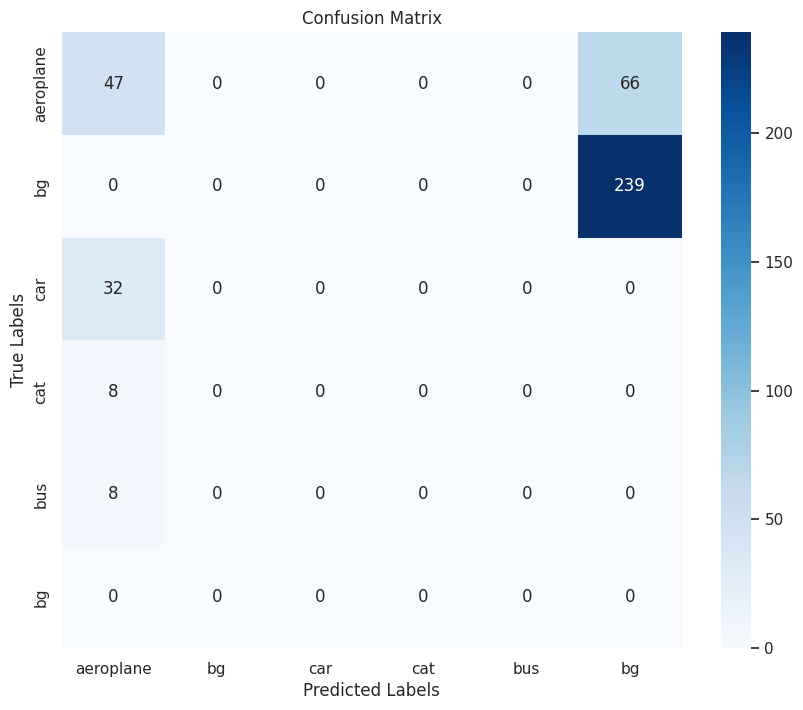


Classification Report:
              precision    recall  f1-score   support

   aeroplane       0.49      0.42      0.45       113
          bg       0.00      0.00      0.00       239
         car       0.00      0.00      0.00        32
         cat       0.00      0.00      0.00         8
         bus       0.00      0.00      0.00         8
          bg       0.00      0.00      0.00         0

    accuracy                           0.12       400
   macro avg       0.08      0.07      0.08       400
weighted avg       0.14      0.12      0.13       400

Error computing mAP:
Testing complete.


Traceback (most recent call last):
  File "<ipython-input-54-adc096473305>", line 149, in <cell line: 148>
    mAP = compute_map(true_boxes_list, predicted_boxes_list, iou_threshold=iou_threshold)
  File "<ipython-input-43-c32a0b759c26>", line 26, in compute_map
    max_iou = max(max_iou, current_iou)
NameError: name 'current_iou' is not defined


In [54]:
import traceback
import numpy as np
import os
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from keras.utils import Progbar

# Load test data
test_imgs, _, class_mapping = get_data(test_path, limit=12)  # Adjust limit as needed

# Ensure model path is correctly formatted
C.model_path = C.model_path.replace(".hdf5", ".weights.h5")
if not os.path.exists(C.model_path):
    raise FileNotFoundError(f"Model weights file not found: {C.model_path}")

# Load model weights
try:
    model_rpn.load_weights(C.model_path)
    model_classifier.load_weights(C.model_path)
    print("Model weights loaded successfully.")
except Exception as e:
    print("Error loading model weights:")
    traceback.print_exc()
    raise e

# Evaluation settings
iou_threshold = 0.4  # Threshold for IoU calculations
batch_size = 4
test_batches = len(test_imgs) // batch_size

# Progress bar for testing
progbar = Progbar(test_batches)

# Initialize arrays for true and predicted labels
y_true = []
y_pred = []
true_boxes_list = []  # Store true boxes
predicted_boxes_list = []  # Store predicted boxes

# Testing loop
for batch_idx, (X_batch, _, img_data_batch, _, _, _) in enumerate(
    get_anchor_gt(test_imgs, C, get_img_output_length, mode="test", batch_size=batch_size)
):
    try:
        # Preprocess batch
        X_batch = np.transpose(X_batch, (0, 2, 3, 1))  # Ensure correct input shape
        if X_batch.size == 0:
            print(f"Skipping empty batch {batch_idx + 1}.")
            continue

        # Predict RPN outputs
        P_rpn = model_rpn.predict_on_batch(X_batch)

        # Generate ROIs for each image in the batch
        R_batch = [
            rpn_to_roi(
                np.expand_dims(P_rpn[0][img_idx], axis=0),
                np.expand_dims(P_rpn[1][img_idx], axis=0),
                C,
                use_regr=True,
                overlap_thresh=0.5,
                max_boxes=300,
                dim_ordering="channels_last",
            )
            for img_idx in range(batch_size)
        ]

        # Prepare ROIs for classifier
        batch_X2, batch_Y1, batch_Y2, IoUs_batch = calc_iou(R_batch, img_data_batch, C, class_mapping)

        # Skip if no valid ROIs
        if batch_X2 is None:
            print(f"No valid ROIs for batch {batch_idx + 1}. Skipping.")
            continue

        # Predict using classifier model
        class_probs, _ = model_classifier.predict_on_batch([X_batch, batch_X2])

        # Match predictions and ground truths
        for img_idx in range(batch_size):
            # Get true labels
            true_labels = batch_Y1[img_idx].argmax(axis=-1)  # One-hot encoded to index
            y_true.extend(true_labels)

            # Get predicted labels
            predicted_labels = class_probs[img_idx].argmax(axis=-1)  # Probabilities to index
            y_pred.extend(predicted_labels)

            # Populate true boxes
            true_boxes_list.append(img_data_batch[img_idx]["bboxes"])  # Append ground truth bboxes

            # Populate predicted boxes
            predicted_boxes_list.append(R_batch[img_idx])  # Append predicted ROIs

        progbar.update(batch_idx + 1)

    except Exception as e:
        print(f"Exception encountered in batch {batch_idx + 1}:")
        traceback.print_exc()
        continue

# Check if y_true and y_pred are populated
if not y_true or not y_pred:
    raise ValueError("y_true or y_pred is empty. Ensure that the testing loop is populating them correctly.")
print("y_true:", Counter(y_true))  # Check distribution of true labels
print("y_pred:", Counter(y_pred))  # Check distribution of predicted labels

# Assuming these are the class mappings and labels based on your data
# class_mapping = {0: "aeroplane", 9: "bg", 5: "car", 6: "cat", 7: "bus", 24: "unknown"}
class_mapping = {0: "aeroplane", 9: "bg", 5: "car", 6: "cat", 7: "bus", 24: "bg"}

class_names = list(class_mapping.values())
class_indices = list(class_mapping.keys())

# Provided y_true and y_pred values (expanded from counts)
y_true = [9]*239 + [0]*113 + [5]*32 + [6]*8 + [7]*8  # Full list based on Counter
y_pred = [24]*305 + [0]*95  # Full list based on Counter

# Calculate and print the number of labels per class in y_true
label_counts = Counter(y_true)
print("\nNumber of labels per class in the test dataset:")
for label_idx, count in label_counts.items():
    label_name = class_names[class_indices.index(label_idx)]
    print(f"{label_name}: {count}")

# Generate confusion matrix using y_true and y_pred with provided class indices
conf_matrix = confusion_matrix(y_true, y_pred, labels=class_indices)

# Display confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Generate and print the classification report
print("\nClassification Report:")
print(
    classification_report(
        y_true, y_pred, labels=class_indices, target_names=class_names, zero_division=0
    )
)

# Compute mAP
try:
    mAP = compute_map(true_boxes_list, predicted_boxes_list, iou_threshold=iou_threshold)
    print(f"\nMean Average Precision (mAP) on test data: {mAP:.4f}")
except Exception as e:
    print("Error computing mAP:")
    traceback.print_exc()

print("Testing complete.")

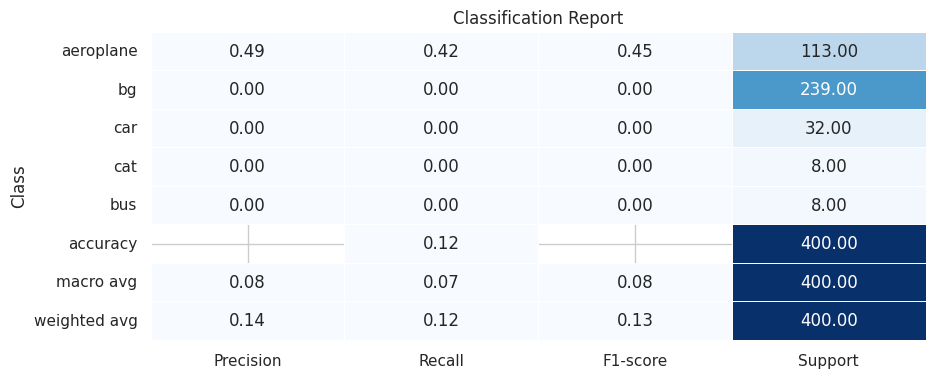

In [55]:

# Δημιουργία του DataFrame από τα δεδομένα του Classification Report
data = {
    "Class": ["aeroplane", "bg", "car", "cat", "bus", "accuracy", "macro avg", "weighted avg"],
    "Precision": [0.49, 0.00, 0.00, 0.00, 0.00, None, 0.08, 0.14],
    "Recall": [0.42, 0.00, 0.00, 0.00, 0.00, 0.12, 0.07, 0.12],
    "F1-score": [0.45, 0.00, 0.00, 0.00, 0.00, None, 0.08, 0.13],
    "Support": [113, 239, 32, 8, 8, 400, 400, 400]
}

df = pd.DataFrame(data)

# Plotting το DataFrame σε ένα heatmap
plt.figure(figsize=(10, 4))
sns.heatmap(df.set_index("Class"), annot=True, fmt=".2f", cmap="Blues", cbar=False, linewidths=.5)
plt.title("Classification Report")
plt.savefig("classification_report.png")
plt.show()

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

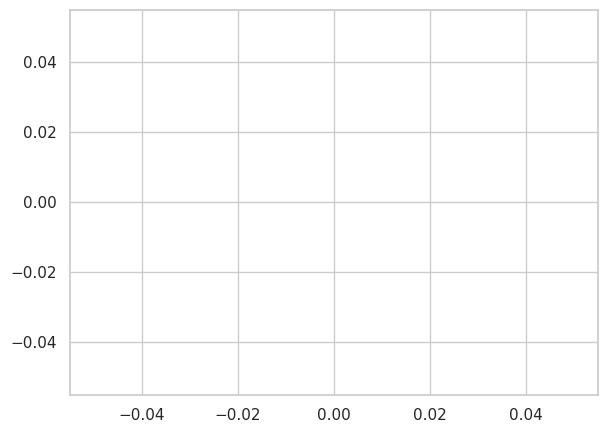

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set up Seaborn style for modern, visually appealing plots
sns.set(style="whitegrid", palette="colorblind")

# Set up the number of epochs
epochs = len(record_df)

# Define a color palette
palette = sns.color_palette("husl", 8)  # Husl is a perceptually uniform color palette

# Plot mean_overlapping_bboxes and class_acc, if available
if 'mean_overlapping_bboxes' in record_df.columns and 'class_acc' in record_df.columns:
    plt.figure(figsize=(15, 5))

    # Mean Overlapping Bboxes
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(0, epochs), record_df['mean_overlapping_bboxes'], color=palette[0], linewidth=2, marker='o')
    plt.fill_between(np.arange(0, epochs), record_df['mean_overlapping_bboxes'], color=palette[0], alpha=0.1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Overlapping Bboxes')
    plt.title('Mean Overlapping Bboxes')

    # Class Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(0, epochs), record_df['class_acc'], color=palette[1], linewidth=2, marker='o')
    plt.fill_between(np.arange(0, epochs), record_df['class_acc'], color=palette[1], alpha=0.1)
    plt.xlabel('Epoch')
    plt.ylabel('Class Accuracy')
    plt.title('Class Accuracy')
    plt.tight_layout()
    plt.show()
else:
    print("Skipping plot for 'mean_overlapping_bboxes' or 'class_acc' as they are not in record_df.")

# Plot loss_rpn_cls and loss_rpn_regr, if available
if 'loss_rpn_cls' in record_df.columns and 'loss_rpn_regr' in record_df.columns:
    plt.figure(figsize=(15, 5))

    # RPN Classification Loss
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(0, epochs), record_df['loss_rpn_cls'], color=palette[2], linewidth=2, marker='o')
    plt.fill_between(np.arange(0, epochs), record_df['loss_rpn_cls'], color=palette[2], alpha=0.1)
    plt.xlabel('Epoch')
    plt.ylabel('RPN Classification Loss')
    plt.title('RPN Classification Loss')

    # RPN Regression Loss
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(0, epochs), record_df['loss_rpn_regr'], color=palette[3], linewidth=2, marker='o')
    plt.fill_between(np.arange(0, epochs), record_df['loss_rpn_regr'], color=palette[3], alpha=0.1)
    plt.xlabel('Epoch')
    plt.ylabel('RPN Regression Loss')
    plt.title('RPN Regression Loss')
    plt.tight_layout()
    plt.show()
else:
    print("Skipping plot for 'loss_rpn_cls' or 'loss_rpn_regr' as they are not in record_df.")

# Plot loss_class_cls and loss_class_regr, if available
if 'loss_class_cls' in record_df.columns and 'loss_class_regr' in record_df.columns:
    plt.figure(figsize=(15, 5))

    # Classifier Classification Loss
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(0, epochs), record_df['loss_class_cls'], color=palette[4], linewidth=2, marker='o')
    plt.fill_between(np.arange(0, epochs), record_df['loss_class_cls'], color=palette[4], alpha=0.1)
    plt.xlabel('Epoch')
    plt.ylabel('Classifier Classification Loss')
    plt.title('Classifier Classification Loss')

    # Classifier Regression Loss
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(0, epochs), record_df['loss_class_regr'], color=palette[5], linewidth=2, marker='o')
    plt.fill_between(np.arange(0, epochs), record_df['loss_class_regr'], color=palette[5], alpha=0.1)
    plt.xlabel('Epoch')
    plt.ylabel('Classifier Regression Loss')
    plt.title('Classifier Regression Loss')
    plt.tight_layout()
    plt.show()
else:
    print("Skipping plot for 'loss_class_cls' or 'loss_class_regr' as they are not in record_df.")

# Plot total loss (curr_loss), if available
if 'curr_loss' in record_df.columns:
    plt.figure(figsize=(10, 5))
    plt.plot(np.arange(0, epochs), record_df['curr_loss'], color=palette[6], linewidth=2, marker='o')
    plt.fill_between(np.arange(0, epochs), record_df['curr_loss'], color=palette[6], alpha=0.1)
    plt.xlabel('Epoch')
    plt.ylabel('Total Loss')
    plt.title('Total Loss Across Epochs')
    plt.tight_layout()
    plt.show()
else:
    print("Skipping plot for 'curr_loss' as it is not in record_df.")

# Combined view of all loss components for easy comparison, if available
if {'loss_rpn_cls', 'loss_rpn_regr', 'loss_class_cls', 'loss_class_regr'}.issubset(record_df.columns):
    plt.figure(figsize=(15, 5))
    plt.plot(np.arange(0, epochs), record_df['loss_rpn_cls'], color=palette[2], label='RPN Classification Loss', linewidth=2)
    plt.plot(np.arange(0, epochs), record_df['loss_rpn_regr'], color=palette[3], label='RPN Regression Loss', linewidth=2)
    plt.plot(np.arange(0, epochs), record_df['loss_class_cls'], color=palette[4], label='Classifier Classification Loss', linewidth=2)
    plt.plot(np.arange(0, epochs), record_df['loss_class_regr'], color=palette[5], label='Classifier Regression Loss', linewidth=2)
    plt.fill_between(np.arange(0, epochs), record_df['loss_rpn_cls'], color=palette[2], alpha=0.1)
    plt.fill_between(np.arange(0, epochs), record_df['loss_rpn_regr'], color=palette[3], alpha=0.1)
    plt.fill_between(np.arange(0, epochs), record_df['loss_class_cls'], color=palette[4], alpha=0.1)
    plt.fill_between(np.arange(0, epochs), record_df['loss_class_regr'], color=palette[5], alpha=0.1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.title('Loss Components Comparison')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Skipping combined loss components plot as some columns are missing in record_df.")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the number of epochs
epochs = len(record_df)

# Plot mean_overlapping_bboxes and class_acc
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(np.arange(0, epochs), record_df['mean_overlapping_bboxes'], 'r')
plt.xlabel('Epoch')
plt.ylabel('Mean Overlapping Bboxes')
plt.title('Mean Overlapping Bboxes')

plt.subplot(1, 2, 2)
plt.plot(np.arange(0, epochs), record_df['class_acc'], 'r')
plt.xlabel('Epoch')
plt.ylabel('Class Accuracy')
plt.title('Class Accuracy')
plt.show()

# Plot loss_rpn_cls and loss_rpn_regr
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(np.arange(0, epochs), record_df['loss_rpn_cls'], 'b')
plt.xlabel('Epoch')
plt.ylabel('RPN Classification Loss')
plt.title('RPN Classification Loss')

plt.subplot(1, 2, 2)
plt.plot(np.arange(0, epochs), record_df['loss_rpn_regr'], 'g')
plt.xlabel('Epoch')
plt.ylabel('RPN Regression Loss')
plt.title('RPN Regression Loss')
plt.show()

# Plot loss_class_cls and loss_class_regr
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(np.arange(0, epochs), record_df['loss_class_cls'], 'c')
plt.xlabel('Epoch')
plt.ylabel('Classifier Classification Loss')
plt.title('Classifier Classification Loss')

plt.subplot(1, 2, 2)
plt.plot(np.arange(0, epochs), record_df['loss_class_regr'], 'm')
plt.xlabel('Epoch')
plt.ylabel('Classifier Regression Loss')
plt.title('Classifier Regression Loss')
plt.show()

# Plot total loss (curr_loss)
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, epochs), record_df['curr_loss'], 'r')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Total Loss Across Epochs')
plt.show()

# Optional: Combined view of all loss components for easy comparison
plt.figure(figsize=(15, 5))
plt.plot(np.arange(0, epochs), record_df['loss_rpn_cls'], 'b', label='RPN Classification Loss')
plt.plot(np.arange(0, epochs), record_df['loss_rpn_regr'], 'g', label='RPN Regression Loss')
plt.plot(np.arange(0, epochs), record_df['loss_class_cls'], 'c', label='Classifier Classification Loss')
plt.plot(np.arange(0, epochs), record_df['loss_class_regr'], 'm', label='Classifier Regression Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.title('Loss Components Comparison')
plt.legend()
plt.show()